In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from collections import defaultdict
import seaborn as sns


df = pd.read_excel('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Raman_Bunmi\\Master_Data\\Data_Master_Sheet1.xlsx', sheet_name = "Master")

In [28]:
# --- Peak models ---
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))

def lorentzian(x, amp, cen, wid):
    return amp * (wid**2 / ((x - cen)**2 + wid**2))

# --- Peak fitting function ---
def fit_peak(x, y, peak_pos, window=5, model="gaussian"):
    # Subset spectrum around the suggested peak
    mask = (x >= peak_pos - window) & (x <= peak_pos + window)
    x_region, y_region = x[mask], y[mask]

    if len(x_region) < 5:  # too few points to fit
        return None

    # Initial guess
    amp_guess = np.max(y_region)
    cen_guess = x_region[np.argmax(y_region)]
    wid_guess = (x_region[-1] - x_region[0]) / 4

    if model == "gaussian":
        func = gaussian
    else:
        func = lorentzian

    try:
        popt, _ = curve_fit(func, x_region, y_region, p0=[amp_guess, cen_guess, wid_guess])
        amp, cen, wid = popt

        # Area and FWHM formulas
        if model == "gaussian":
            fwhm = 2.3548 * wid
            area = amp * wid * np.sqrt(2 * np.pi)
        else:  # Lorentzian
            fwhm = 2 * wid
            area = np.pi * amp * wid

        return {"peak_pos": peak_pos, "fit_pos": cen, "amp": amp, "fwhm": fwhm, "area": area}

    except RuntimeError:
        return None

# --- Main function ---
def analyze_spectra(df, peak_positions, model="gaussian"):
    results = []
    x = df.iloc[:, 7:].columns.astype(float).values

    # Average spectra by group
   # grouped = df.drop(['exp', 'spectra_num'], axis=1).groupby("details").mean(numeric_only=True)
    dff = df.iloc[:, 6:].set_index('details1')

    for peak in peak_positions:
        for group, spectrum in dff.iterrows():
        #grouped.iterrows():
            y = spectrum.values
            fit = fit_peak(x, y, peak, model=model)
            if fit:
                fit["group"] = group
                results.append(fit)

                # Plot
                '''plt.figure(figsize=(6, 4))
                plt.plot(x, y, label=f"{group} spectrum")
                plt.axvline(peak, color="gray", linestyle="--", lw=0.5, label="suggested peak")

                # Overlay fitted peak
                if model == "gaussian":
                    fit_curve = gaussian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2.3548)
                else:
                    fit_curve = lorentzian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2)
                plt.plot(x, fit_curve, "r--", label=f"Fitted {model}")

                plt.title(f"Peak fit near {peak} cm⁻¹ ({group})")
                plt.xlabel("Raman Shift (cm⁻¹)")
                plt.ylabel("Intensity (a.u.)")
                plt.legend()
                plt.show()'''

    return pd.DataFrame(results)



In [29]:
def plot_spectra(df, peak_positions, model="gaussian"):
    x = df.iloc[:, 7:].columns.astype(float).values
    grouped = df.drop(['exp', 'spectra_num'], axis=1).groupby("details1").mean(numeric_only=True)
    for group, spectrum in grouped.iterrows():
                y = spectrum.values
                fits_for_group = []

                plt.figure(figsize=(8, 5))
                plt.plot(x, y, label=f"{group} spectrum", color="black")

                for peak in peak_positions:
                    fit = fit_peak(x, y, peak, model=model)
                    if fit:
                        fit["group"] = group
                        fits_for_group.append(fit)
                        #results.append(fit)
        # overlay fitted curve
                        if model == "gaussian":
                            fit_curve = gaussian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2.3548)
                        else:  # lorentzian
                            fit_curve = lorentzian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2)

                        plt.plot(x, fit_curve, "--", label=f"Fit @ {fit['fit_pos']:.1f} cm⁻¹")

                        # vertical line at target peak
                        plt.axvline(peak, color="gray", linestyle=":", lw=0.8)

                plt.title(f"Peak fits for {group}")
                plt.xlabel("Raman Shift (cm⁻¹)")
                plt.ylabel("Intensity (a.u.)")
                plt.legend(fontsize=8)
                plt.tight_layout()
                plt.show()


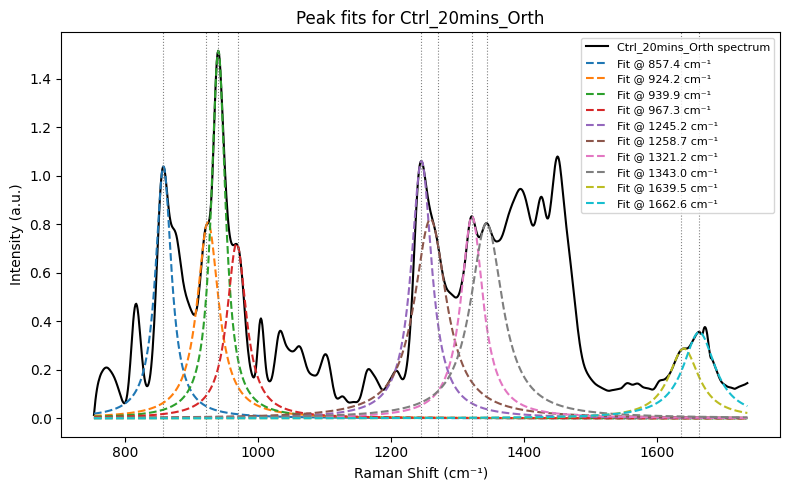

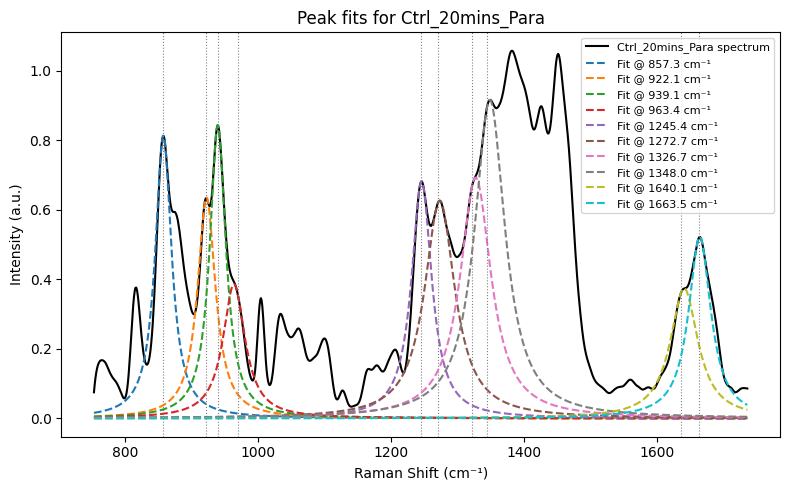

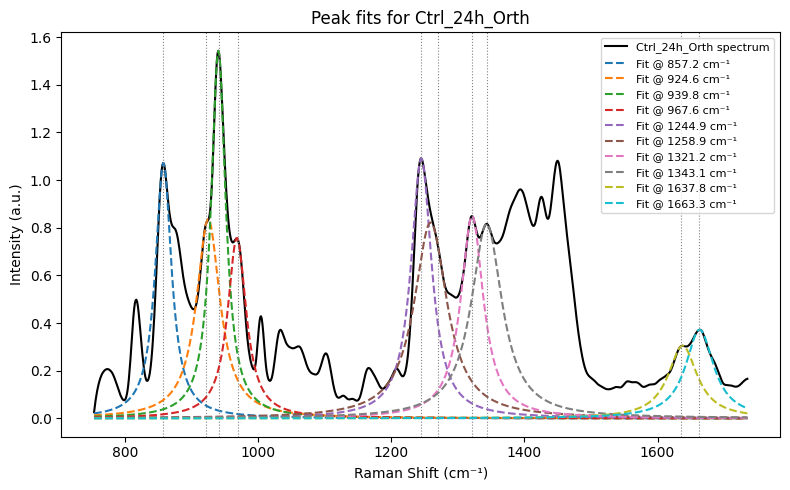

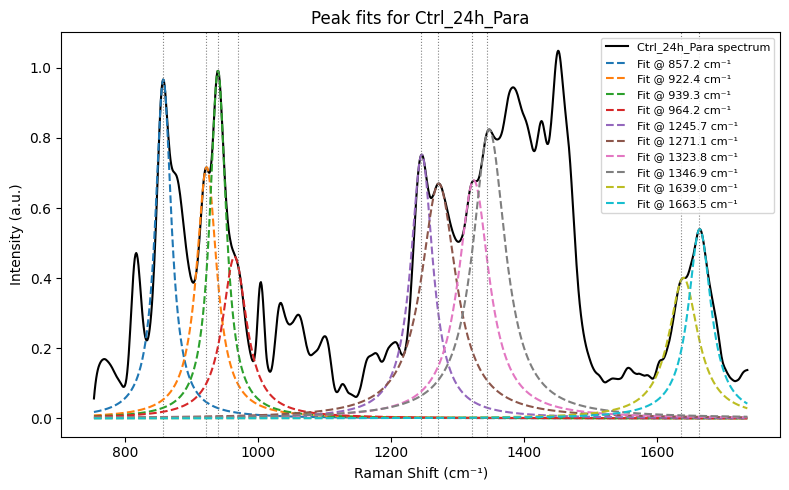

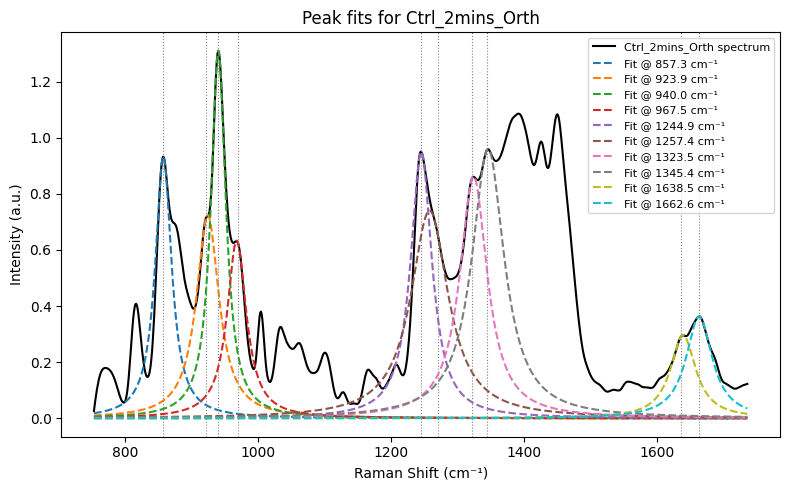

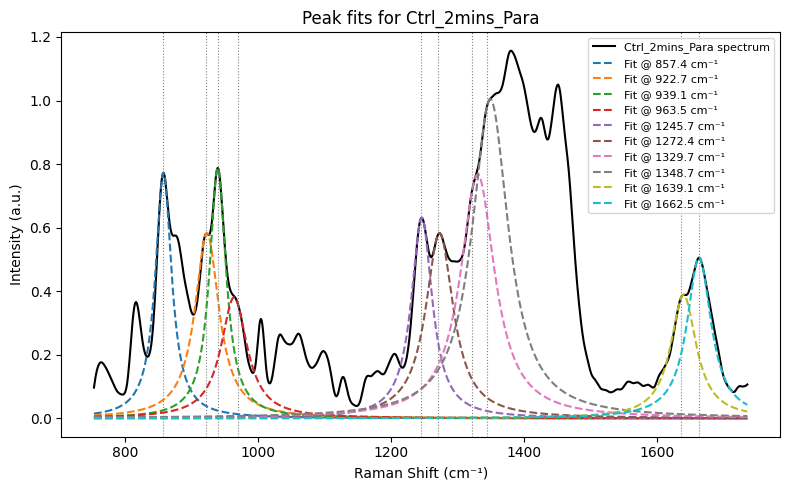

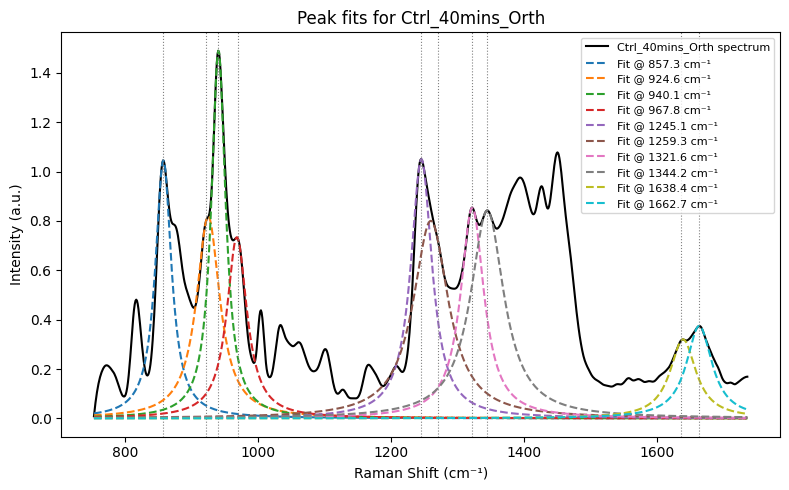

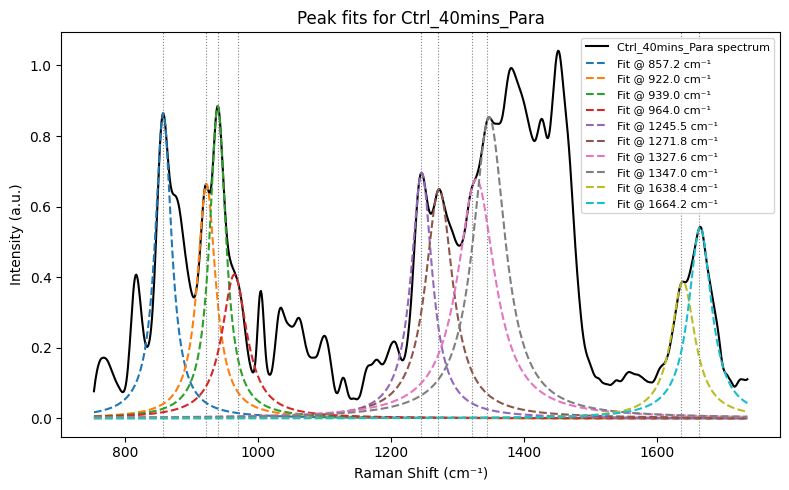

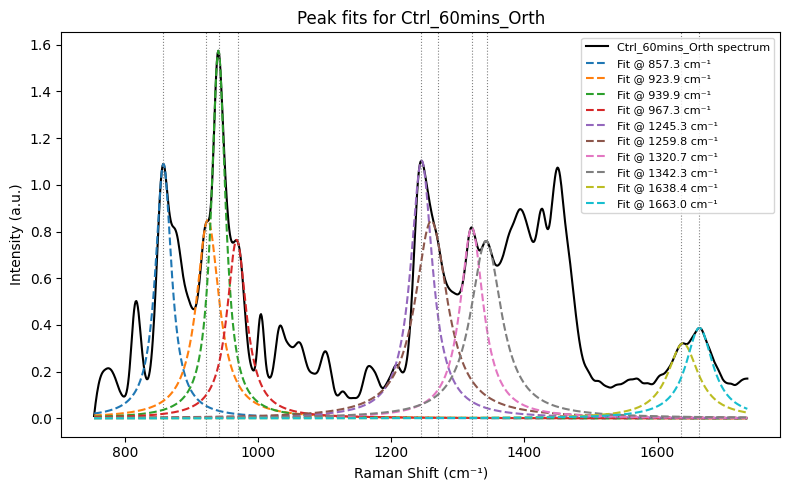

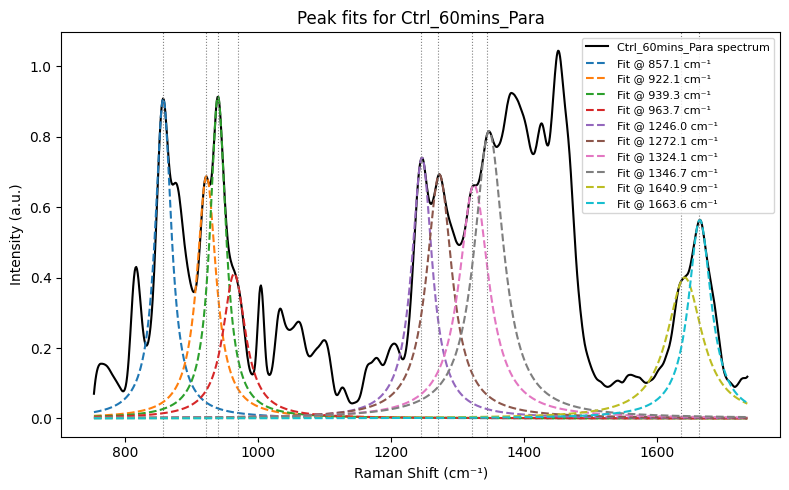

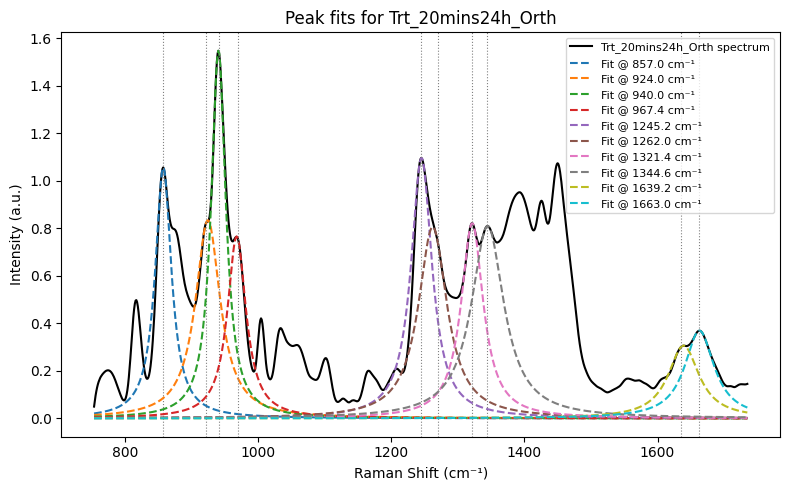

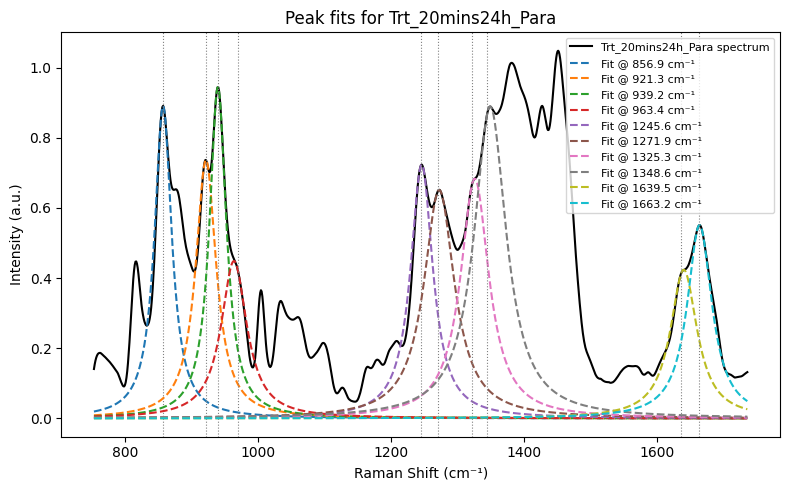

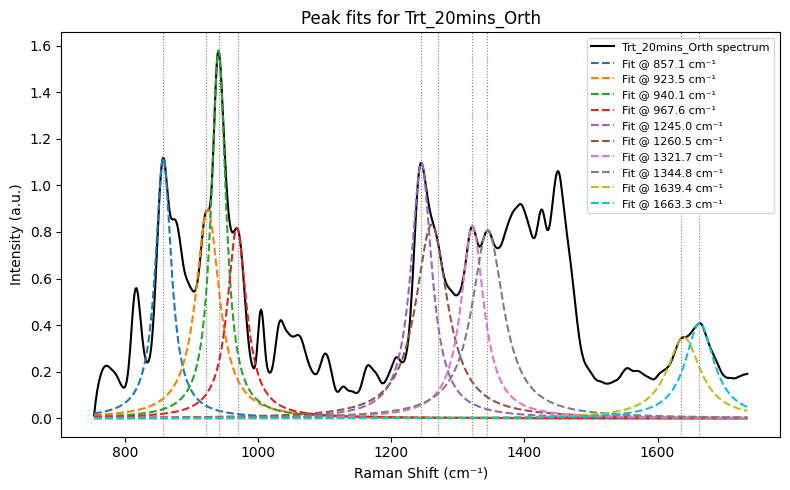

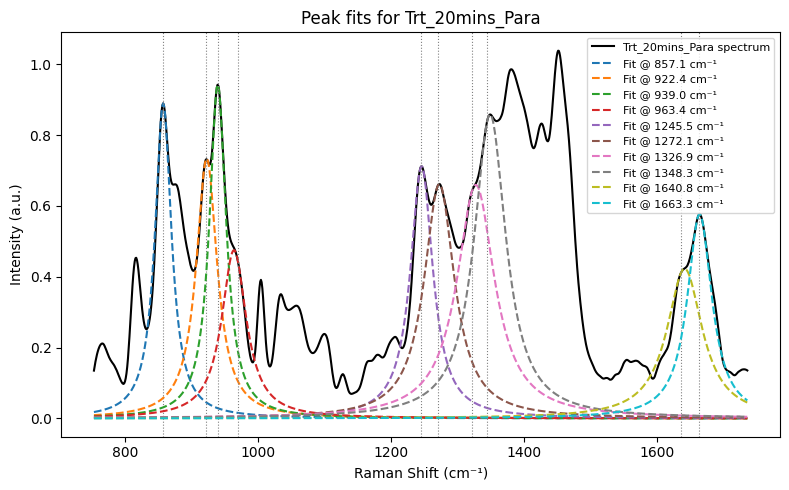

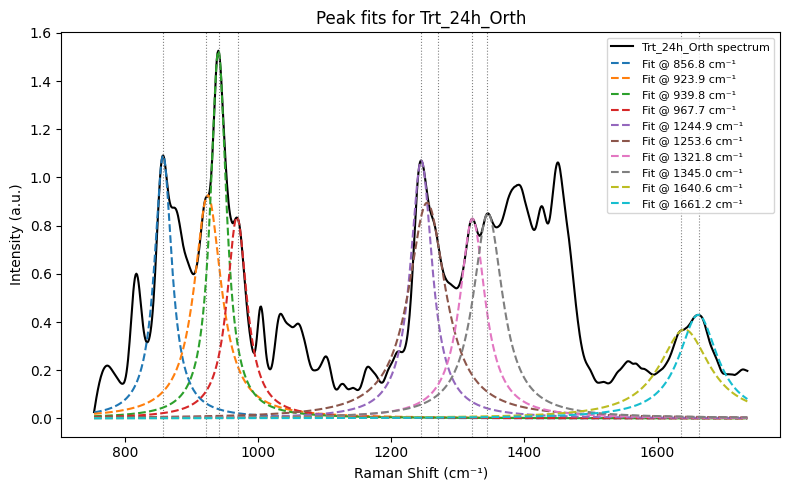

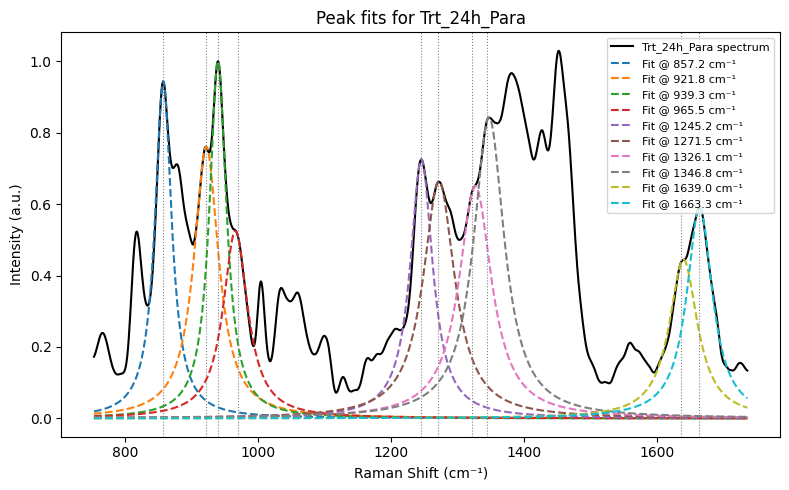

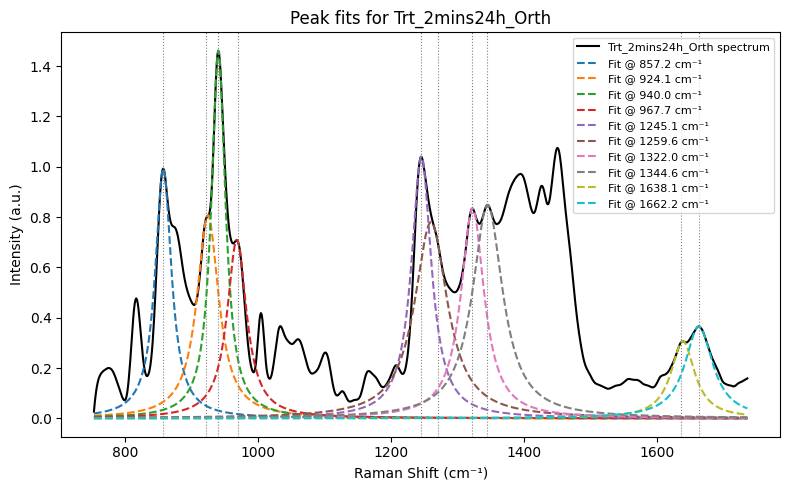

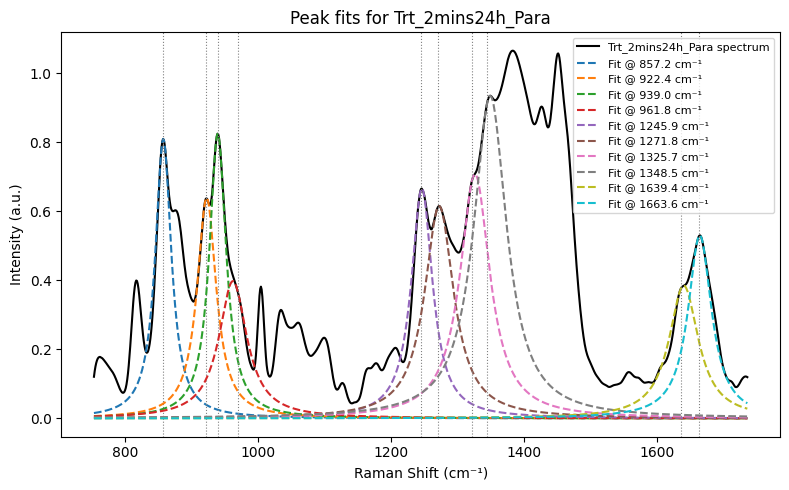

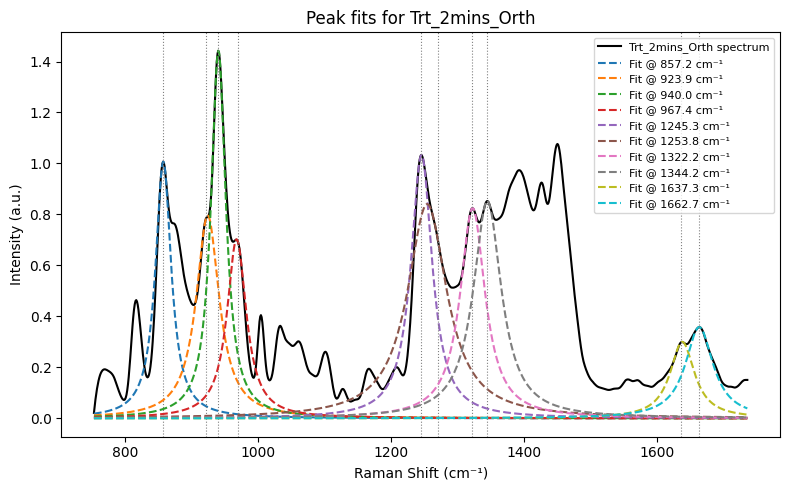

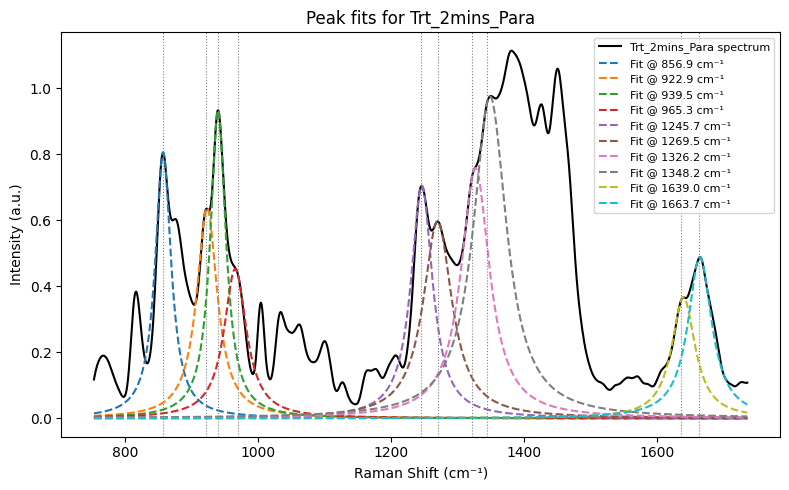

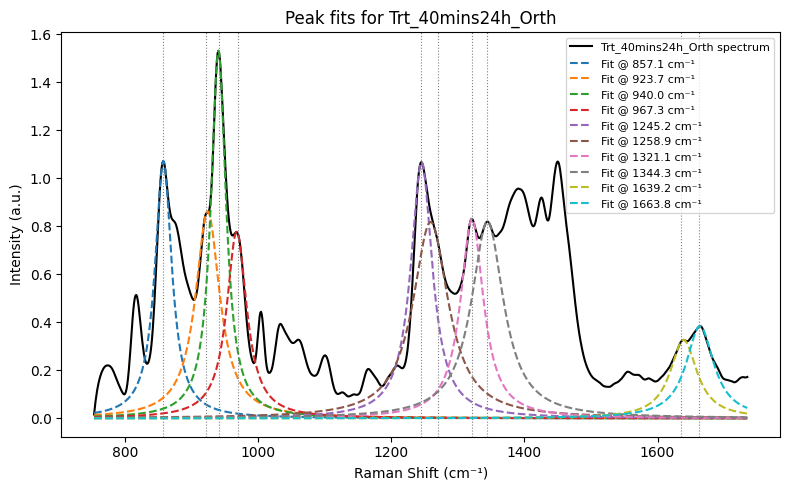

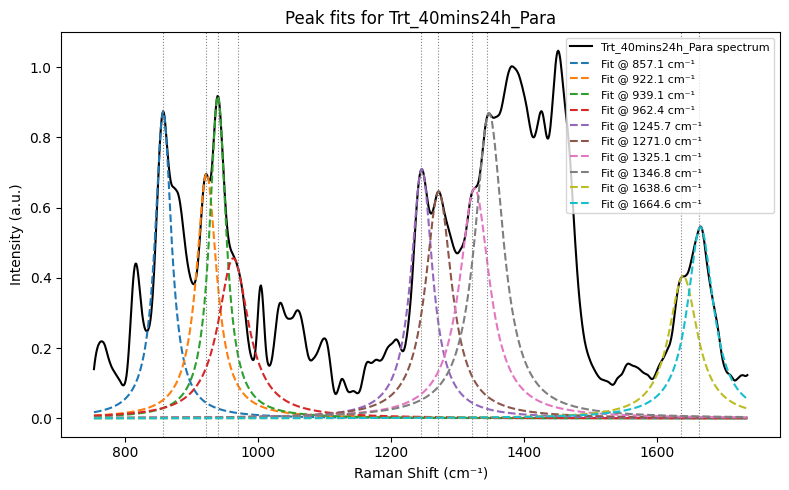

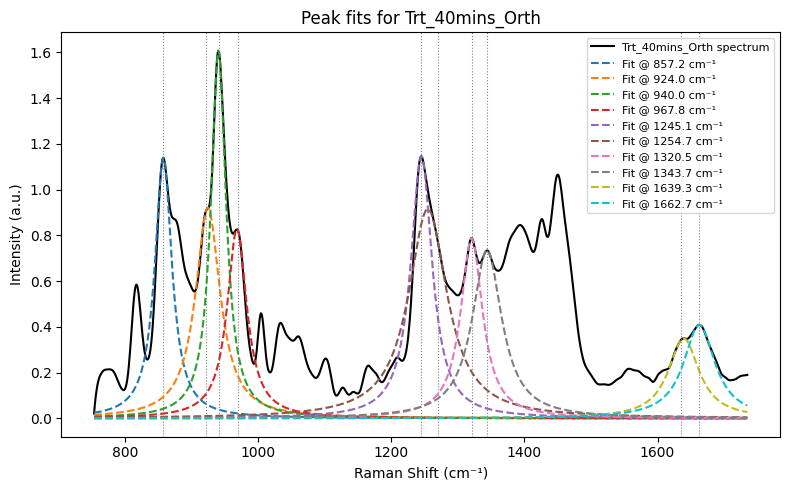

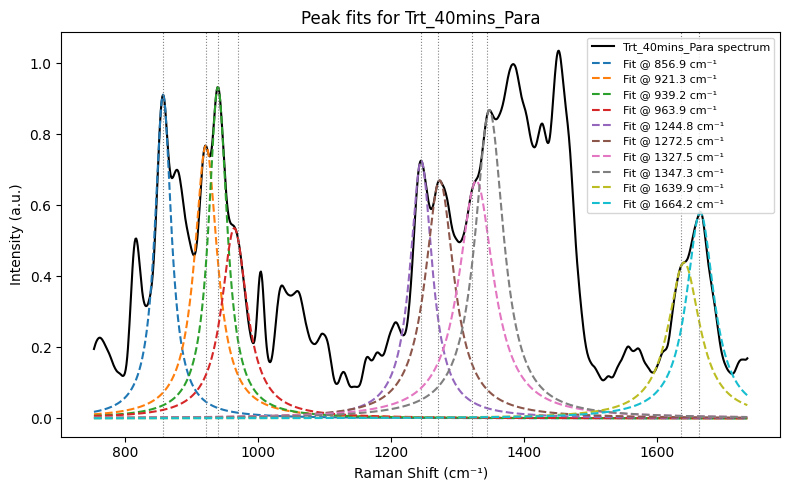

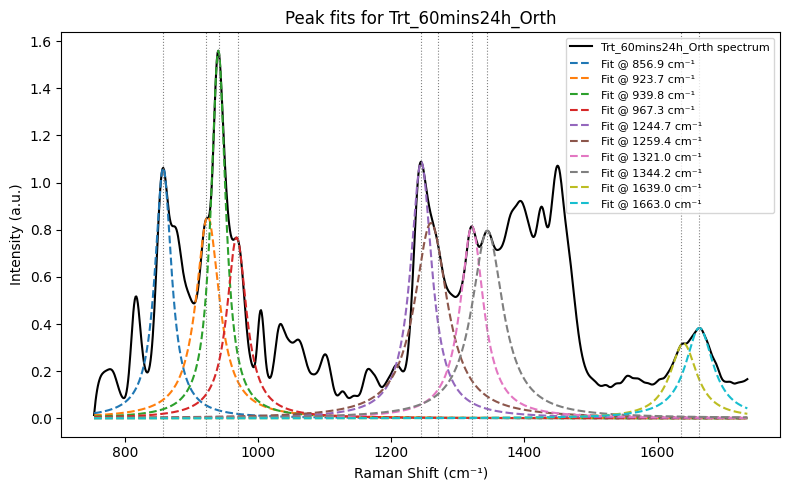

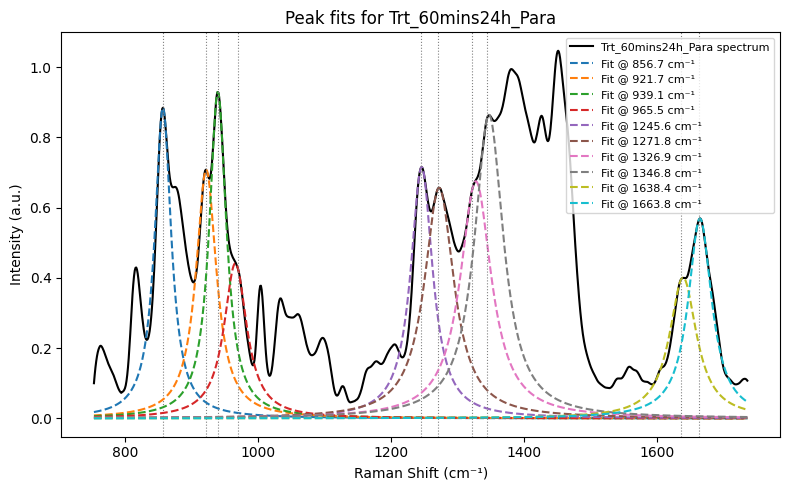

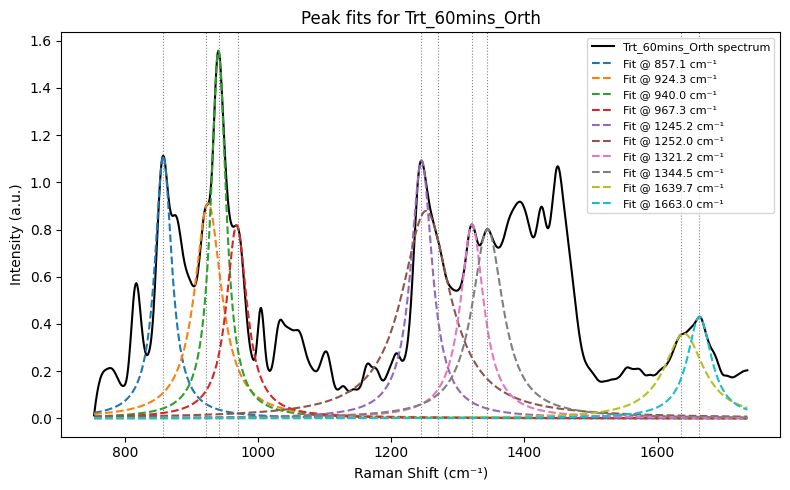

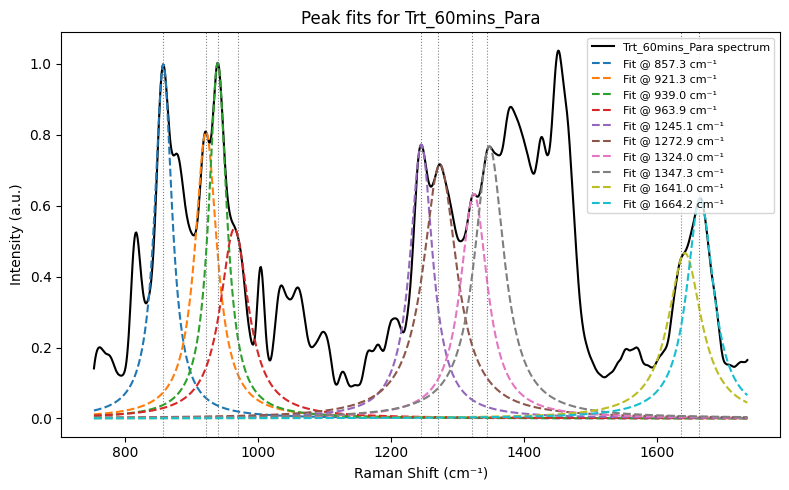

In [30]:
peak_positions = [857, 921, 940, 970, 1245, 1270, 1321, 1344, 1636, 1663]
results = plot_spectra(df, peak_positions, model="lorentzian")

In [25]:
# --- Example usage ---
#df = pd.read_csv("raman_spectra.csv")  # must include a 'details' column peak_positions = [1000, 1200, 1450, 1650]
peak_positions = [857, 921, 940, 970, 1245, 1270, 1321, 1344, 1636, 1663]
results = analyze_spectra(df, peak_positions, model="gaussian")
#print(results)

In [26]:
results

peak_pos      fit_pos       amp        fwhm       area             group
0          857   859.219901  1.058255   23.008170  25.918407  Ctrl_20mins_Orth
1          857   859.685794  1.062201   24.501746  27.703824  Ctrl_20mins_Orth
2          857   859.355651  1.208335   30.040827  38.639809  Ctrl_20mins_Orth
3          857   860.004124  1.111571   24.072551  28.483618  Ctrl_20mins_Orth
4          857   859.124443  1.192610   27.555283  34.981561  Ctrl_20mins_Orth
...        ...          ...       ...         ...        ...               ...
8402      1663  1669.611137  0.590874   64.279495  40.429967   Trt_60mins_Para
8403      1663  1665.746107  0.861600   48.717523  44.681399   Trt_60mins_Para
8404      1663  1663.317140  0.811862   40.720978  35.191393   Trt_60mins_Para
8405      1663  1665.430837  0.615799   50.479249  33.089315   Trt_60mins_Para
8406      1663  1650.922256  0.764061  108.865997  88.543363   Trt_60mins_Para

[8407 rows x 6 columns]

In [104]:
results['group'].str.split('_', expand=True).rename({0: 'sample', 1: 'trt_time', 2: 'orient'}, axis=1)#.drop([3], axis=1)

sample trt_time orient
0      Ctrl   20mins   Orth
1      Ctrl   20mins   Orth
2      Ctrl   20mins   Orth
3      Ctrl   20mins   Orth
4      Ctrl   20mins   Orth
...     ...      ...    ...
8402    Trt   60mins   Para
8403    Trt   60mins   Para
8404    Trt   60mins   Para
8405    Trt   60mins   Para
8406    Trt   60mins   Para

[8407 rows x 3 columns]

In [113]:
dt = results['group'].str.split('_', expand=True).rename({0: 'sample', 1: 'trt_time', 2: 'orient'}, axis=1)
result_df = pd.concat([dt, results], axis=1)

In [118]:
result_df['peak_pos'].unique()

array([ 857,  921,  940,  970, 1245, 1270, 1321, 1344, 1636, 1663])

In [152]:
result_df

sample trt_time orient  peak_pos      fit_pos       amp        fwhm  \
0      Ctrl   20mins   Orth       857   859.219901  1.058255   23.008170   
1      Ctrl   20mins   Orth       857   859.685794  1.062201   24.501746   
2      Ctrl   20mins   Orth       857   859.355651  1.208335   30.040827   
3      Ctrl   20mins   Orth       857   860.004124  1.111571   24.072551   
4      Ctrl   20mins   Orth       857   859.124443  1.192610   27.555283   
...     ...      ...    ...       ...          ...       ...         ...   
8402    Trt   60mins   Para      1663  1669.611137  0.590874   64.279495   
8403    Trt   60mins   Para      1663  1665.746107  0.861600   48.717523   
8404    Trt   60mins   Para      1663  1663.317140  0.811862   40.720978   
8405    Trt   60mins   Para      1663  1665.430837  0.615799   50.479249   
8406    Trt   60mins   Para      1663  1650.922256  0.764061  108.865997   

           area             group  
0     25.918407  Ctrl_20mins_Orth  
1     27.703824  Ctrl_20mins_Orth  
2     38.639809  Ctrl_20mins_Orth  
3     28.483618  Ctrl_20mins_Orth  
4     34.981561  Ctrl_20mins_Orth  
...         ...               ...  
8402  40.429967   Trt_60mins_Para  
8403  44.681399   Trt_60mins_Para  
8404  35.191393   Trt_60mins_Para  
8405  33.089315   Trt_60mins_Para  
8406  88.543363   Trt_60mins_Para  

[8407 rows x 9 columns]

KeyboardInterrupt: 

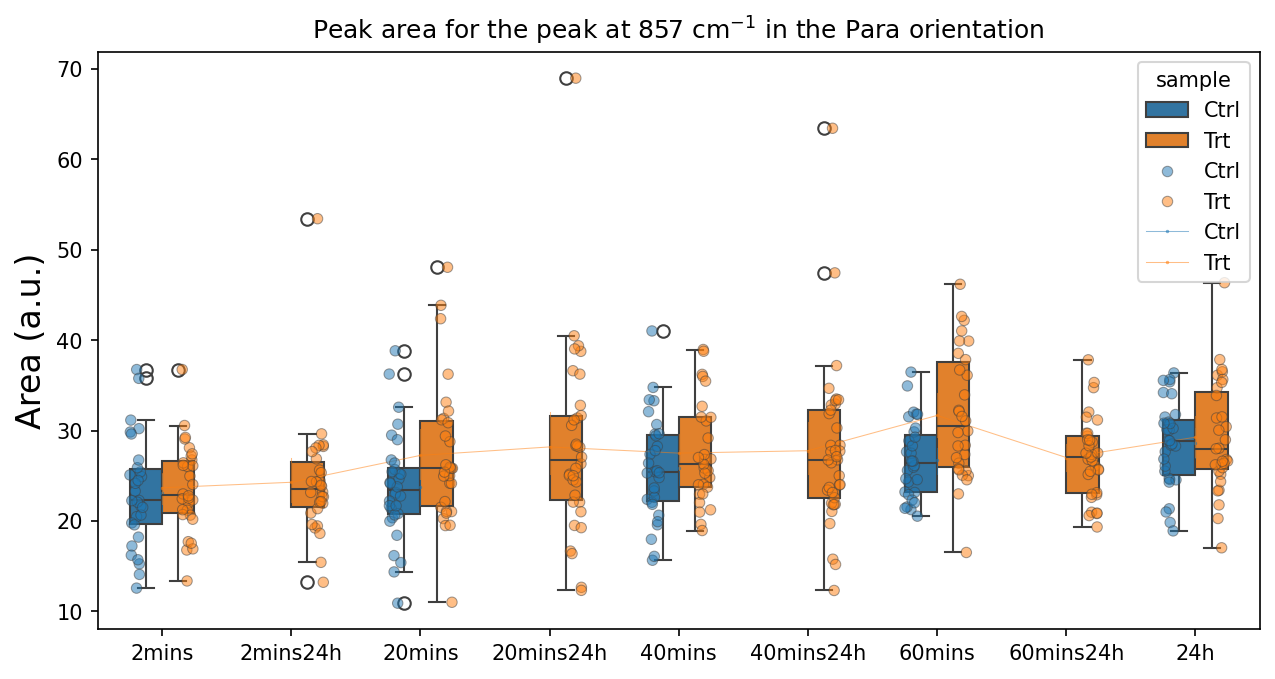

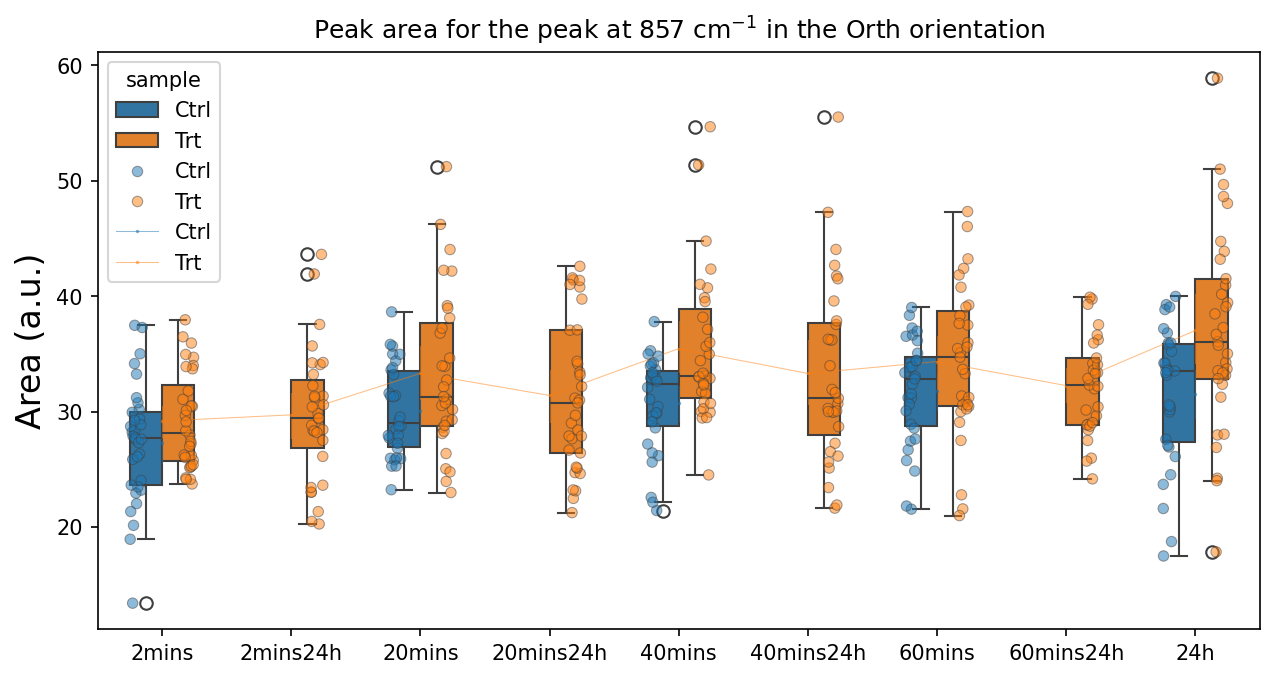

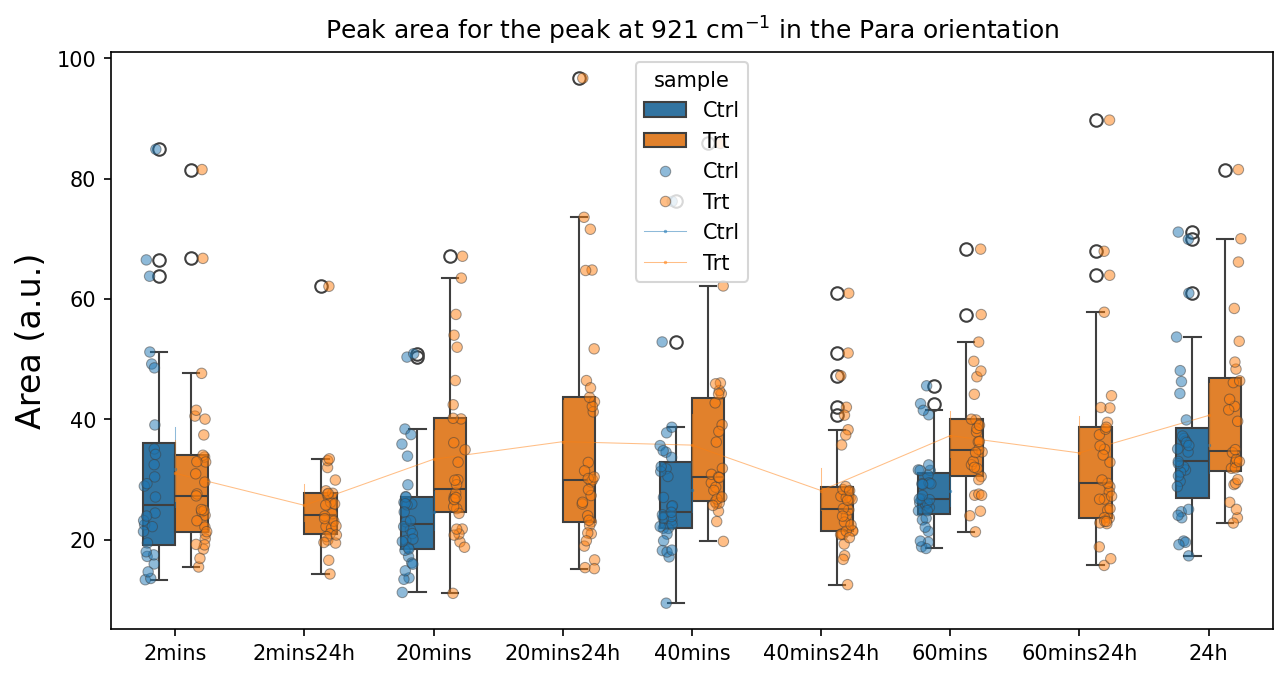

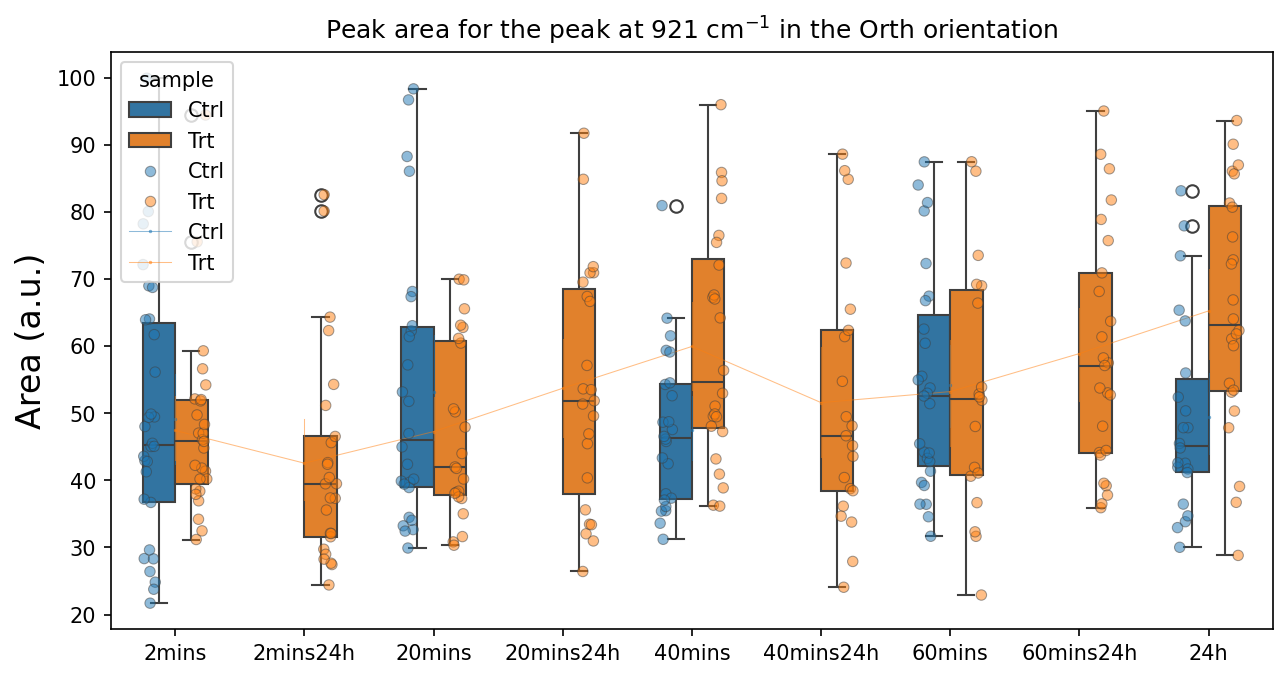

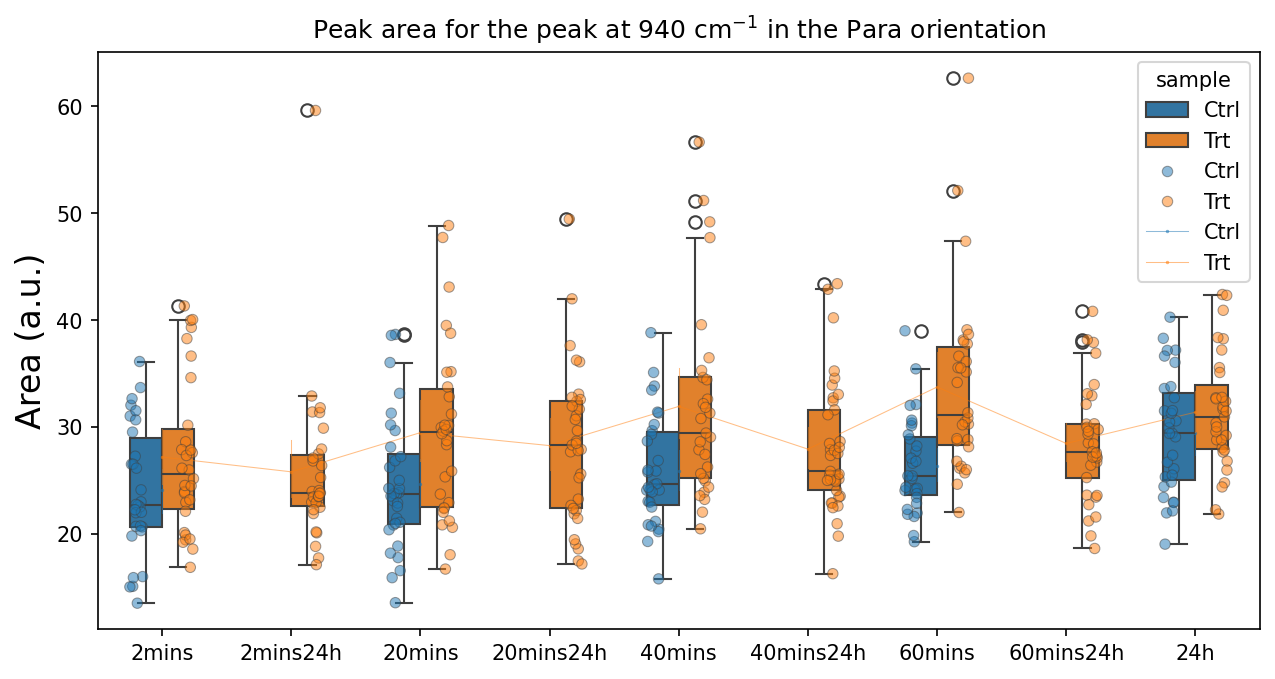

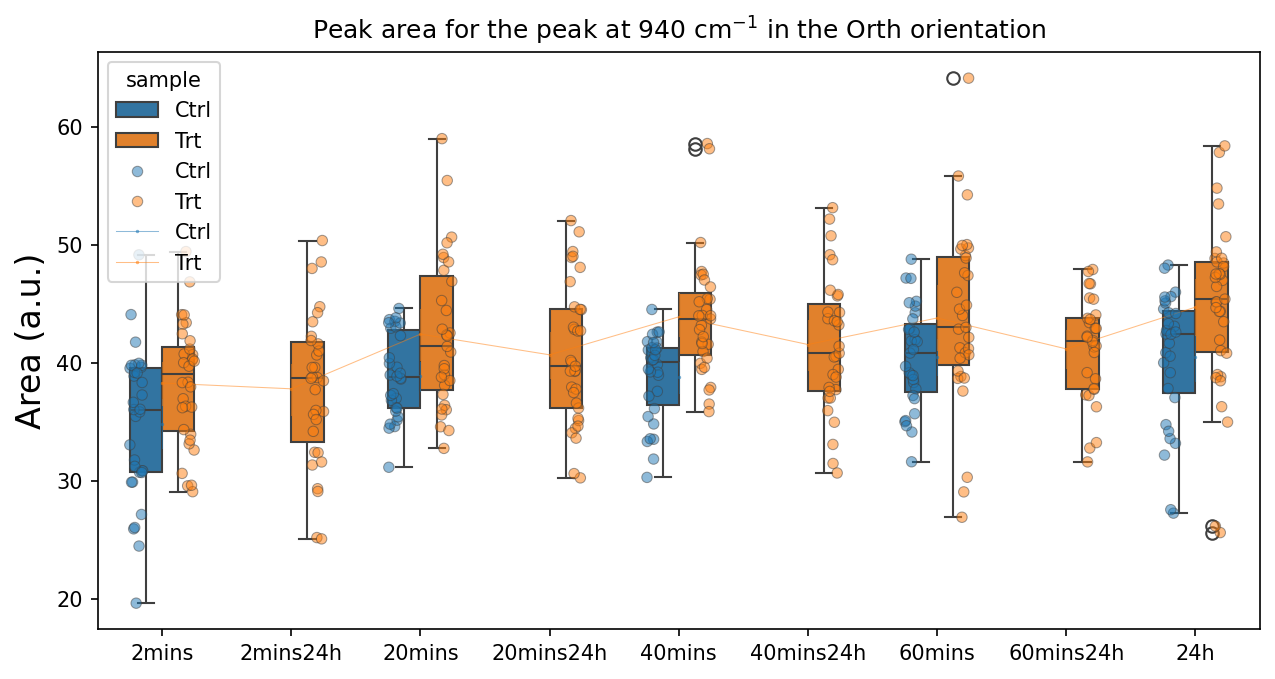

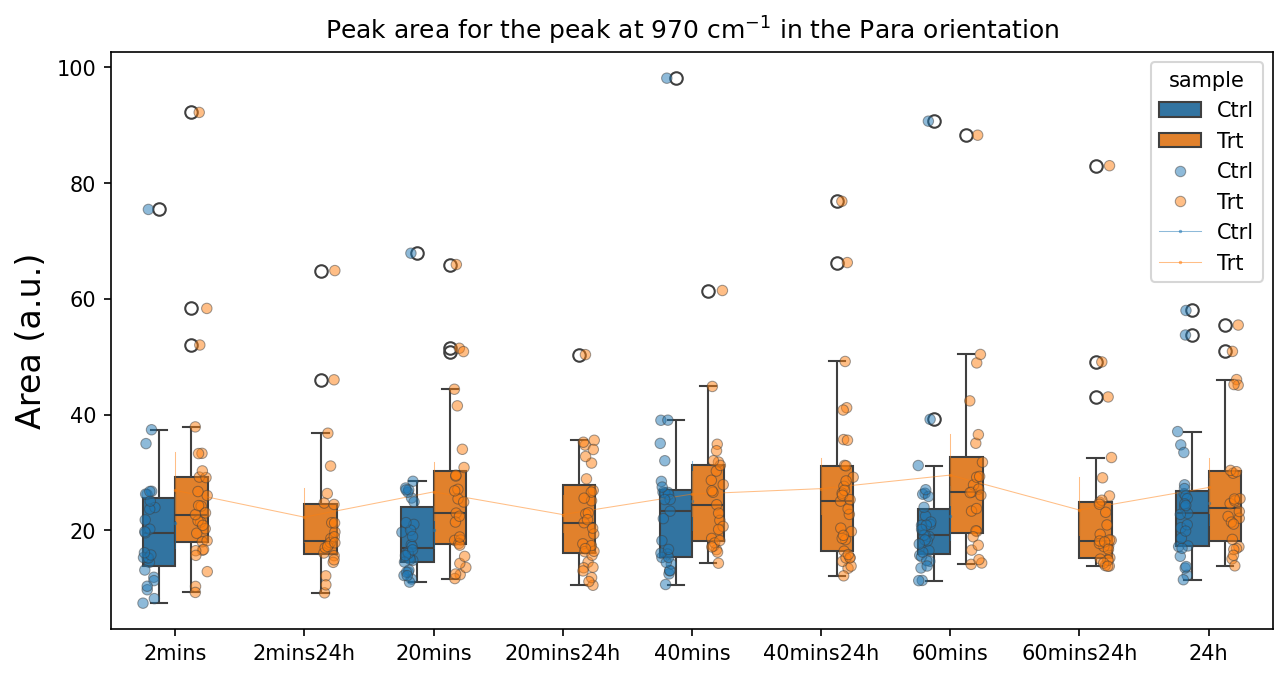

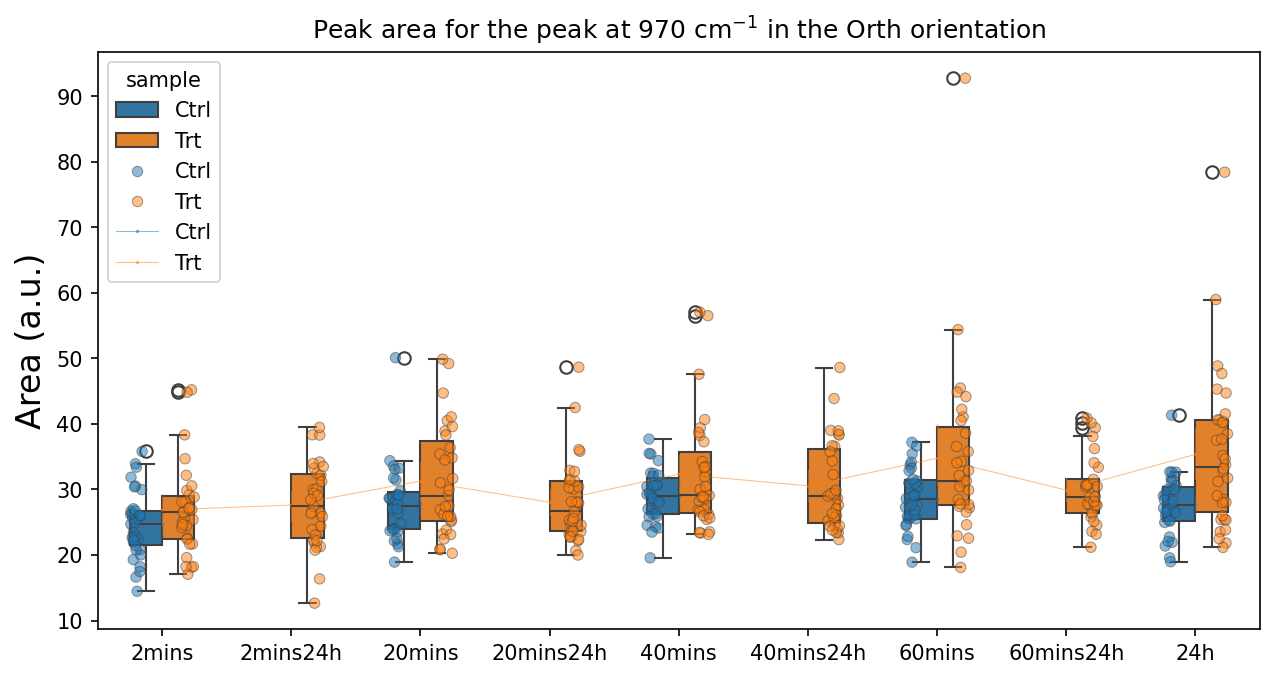

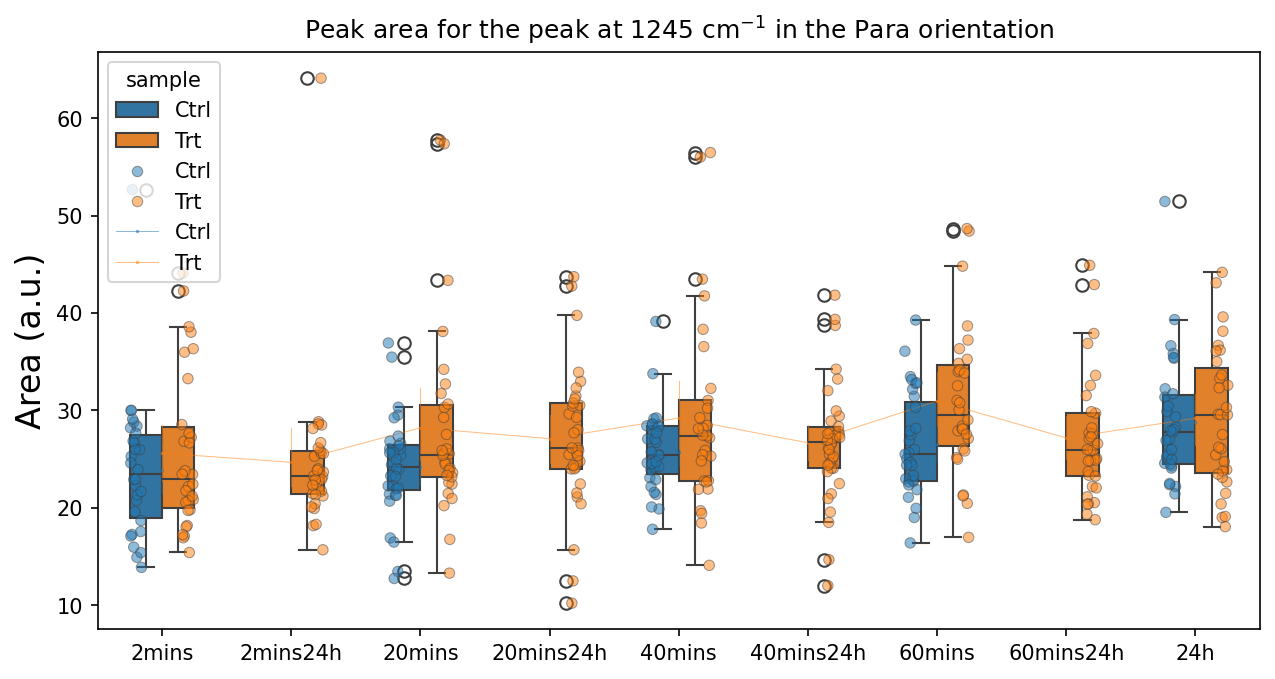

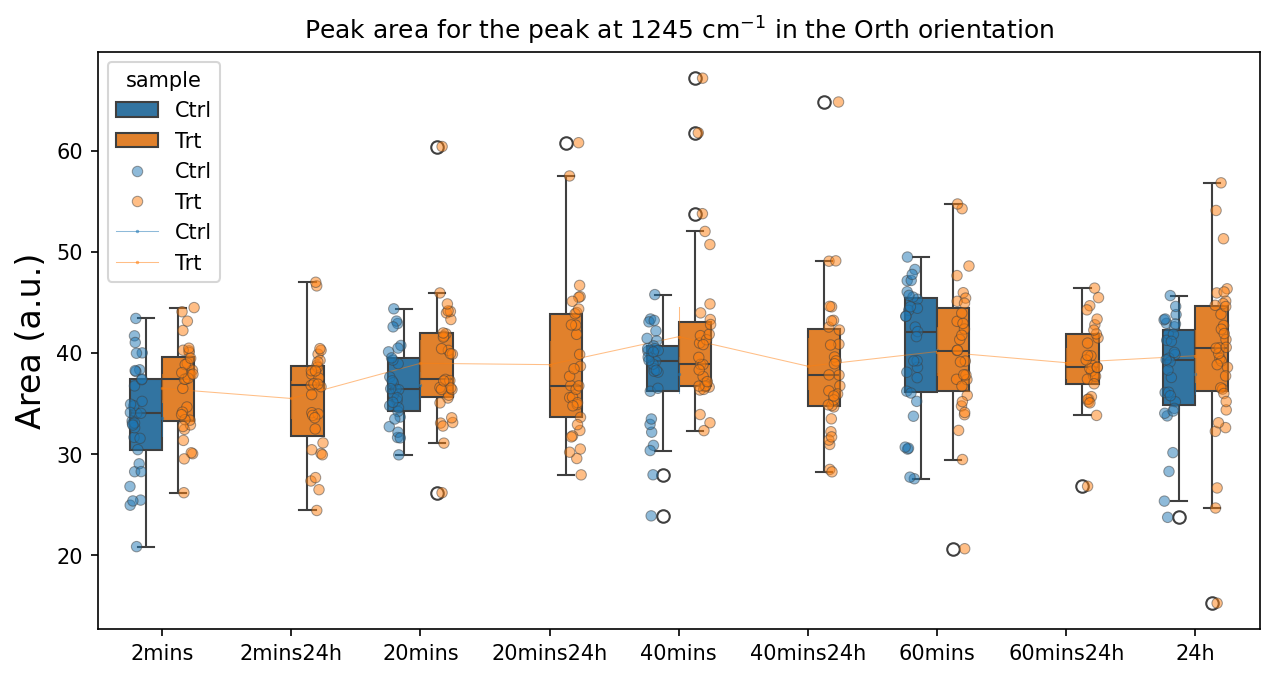

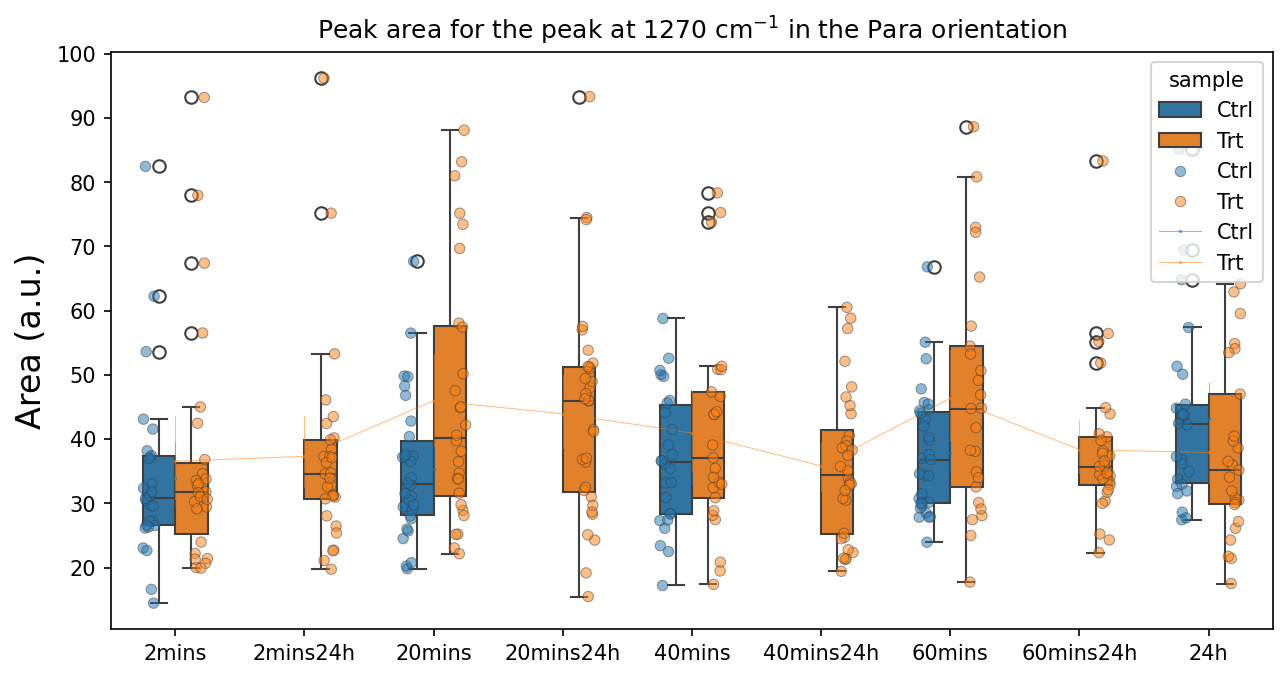

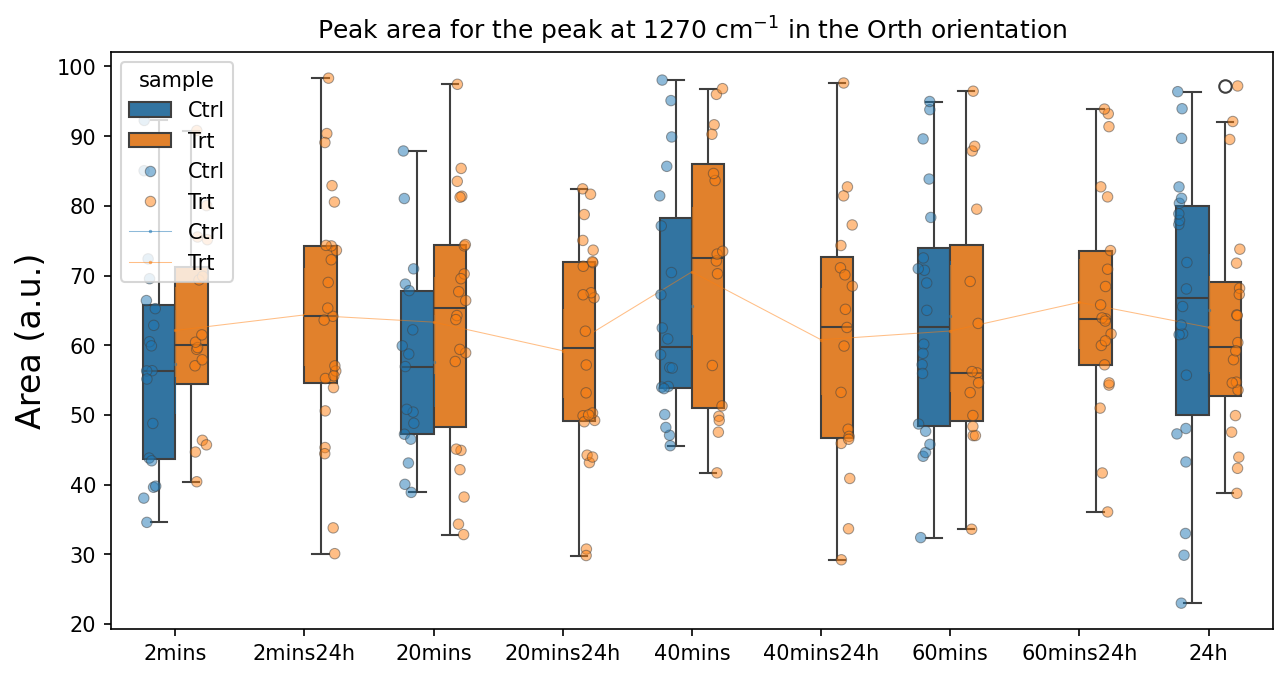

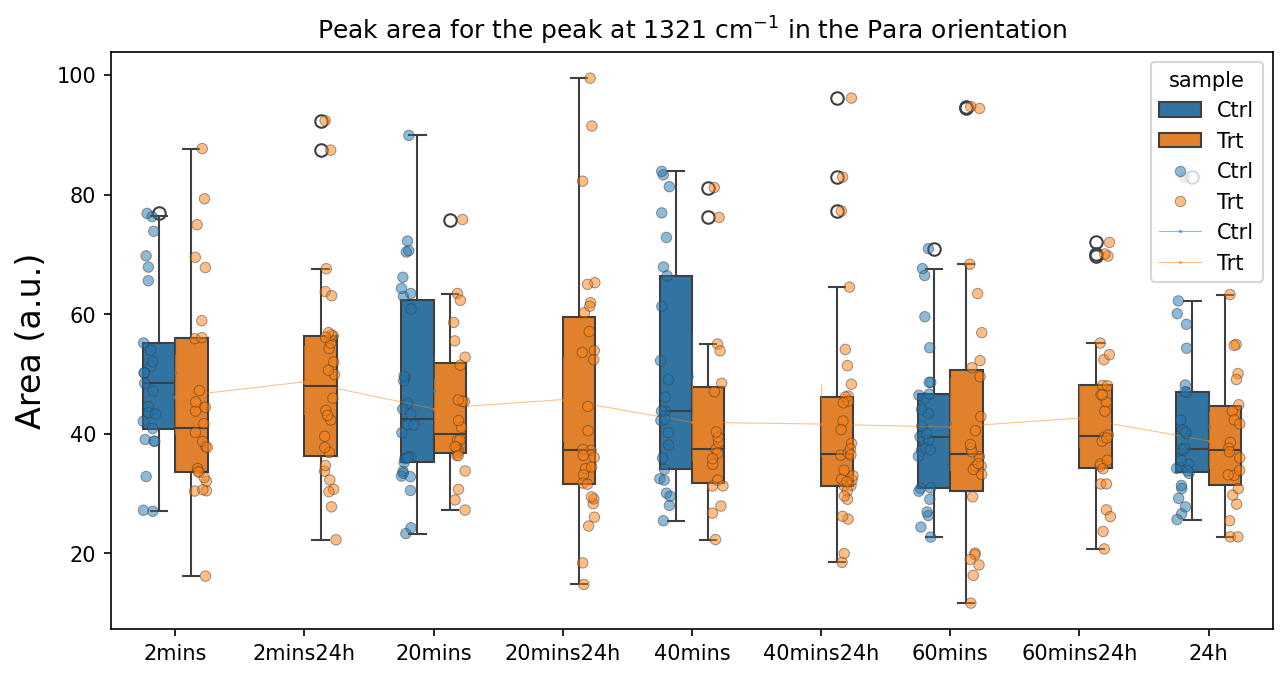

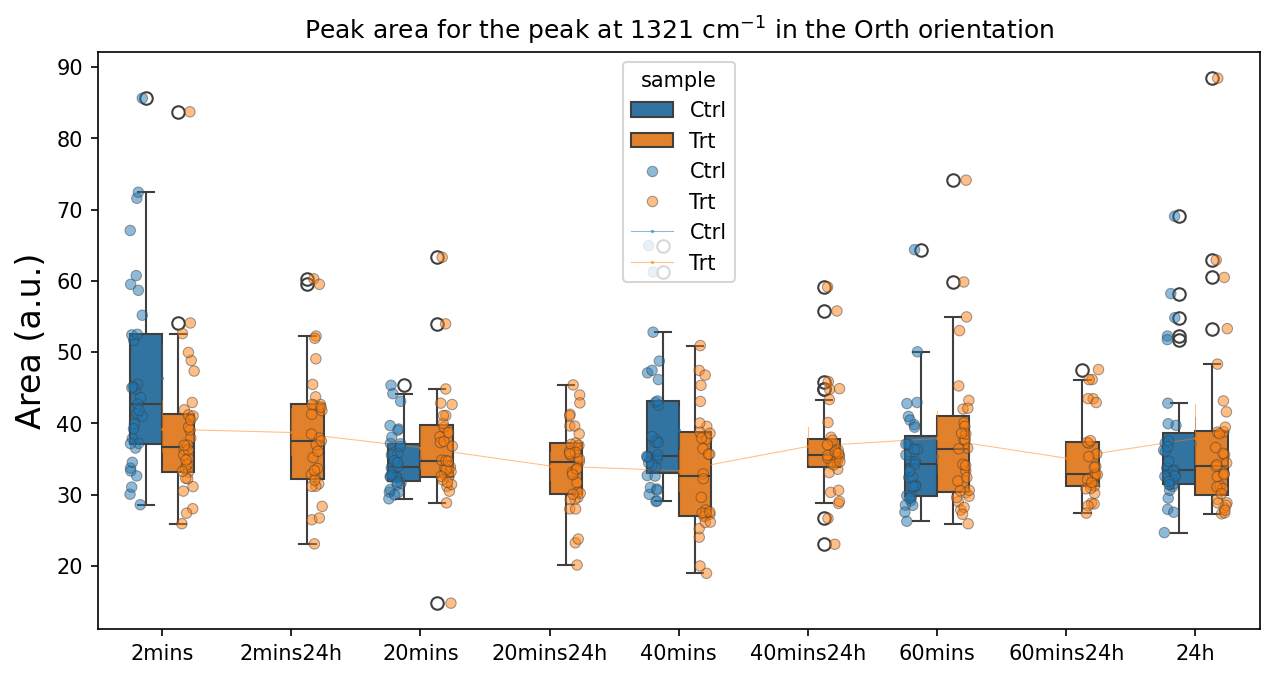

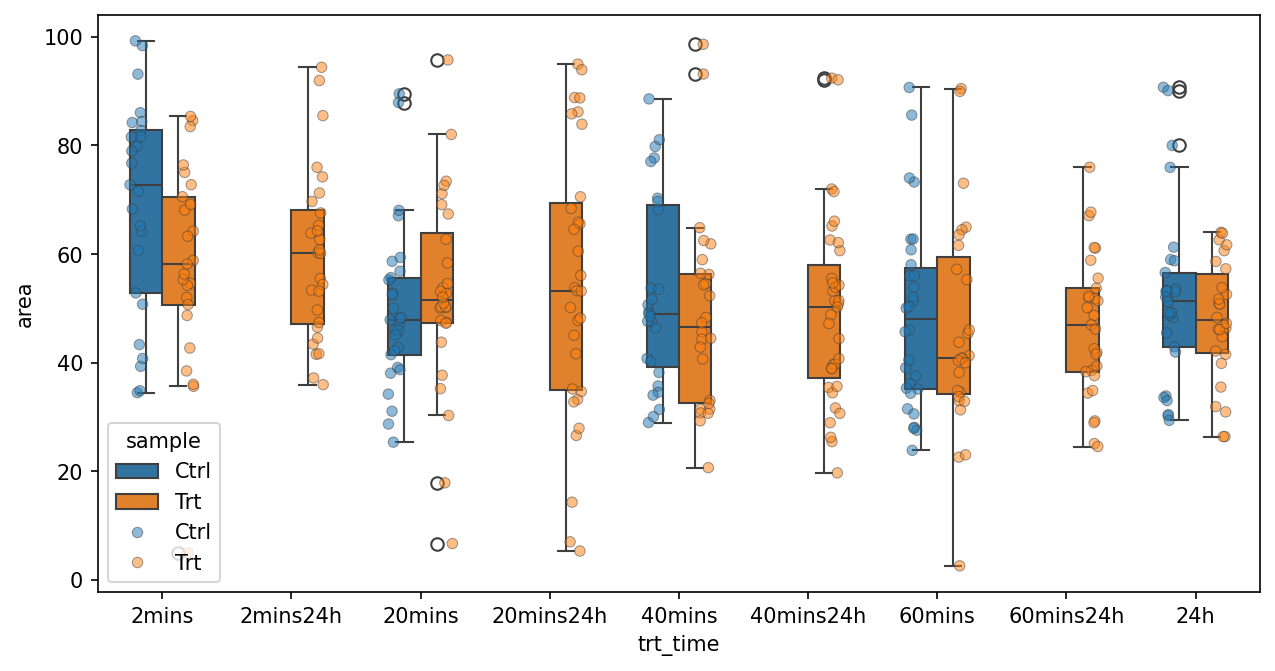

In [159]:
for p in peak_positions:
    for j, tp in enumerate(['Para', 'Orth']):
        plt.figure(figsize = (10, 5), dpi = 150);
        dtt = result_df[(result_df['orient'].str.contains(tp)) & 
                                    (result_df['peak_pos'] == p) &
                                    (result_df['area']<= 100) #&
                                    #(result_df[''])
                                    ]
                #plt.figure(figsize = (15, 9), dpi = 150);
        sns.boxplot(
                    data = dtt,
                        x = 'trt_time',
                        y = 'area',
                        hue = 'sample',
                        order = ['2mins','2mins24h','20mins', '20mins24h','40mins', '40mins24h',  '60mins', 
                            '60mins24h', '24h'],
                            width = .5,
                           #alpha = .5
                    );
        sns.stripplot(
                    data = dtt,
                        x = 'trt_time',
                        y = 'area',
                        hue = 'sample',
                        order = ['2mins','2mins24h','20mins', '20mins24h','40mins', '40mins24h',  '60mins', 
                            '60mins24h', '24h'],
                            dodge = .5, linewidth = .5,
                           alpha = .5
                    );
        plt.title(f'Peak area for the peak at {p} cm$^{{-1}}$ in the {tp} orientation')
        plt.ylabel('Area (a.u.)', fontsize = 16)
        plt.xlabel('')

In [141]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for p in peak_positions:
    dtt = result_df[(result_df['orient'].str.contains('Orth')) & 
                                    (result_df['peak_pos'] == p) #&
                                    #(result_df['area']<= 100)
                                    ]
    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=dtt['area'],
                            groups=dtt['sample'],
                            alpha=0.05)

    #display results
    print(f'Tukey HSD results for peak at {p} cm$^{-1}$ in the Parallel Orientation')
    print(tukey)
    print('*******************************************************************************')

Tukey HSD results for peak at 857 cm$^-1$ in the Parallel Orientation
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Ctrl    Trt   4.8435 0.1107 -1.1118 10.7988  False
----------------------------------------------------
*******************************************************************************
Tukey HSD results for peak at 921 cm$^-1$ in the Parallel Orientation
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper   reject
-----------------------------------------------------
  Ctrl    Trt   89.452 0.0611 -4.2016 183.1055  False
-----------------------------------------------------
*******************************************************************************
Tukey HSD results for peak at 940 cm$^-1$ in the Parallel Orientation
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

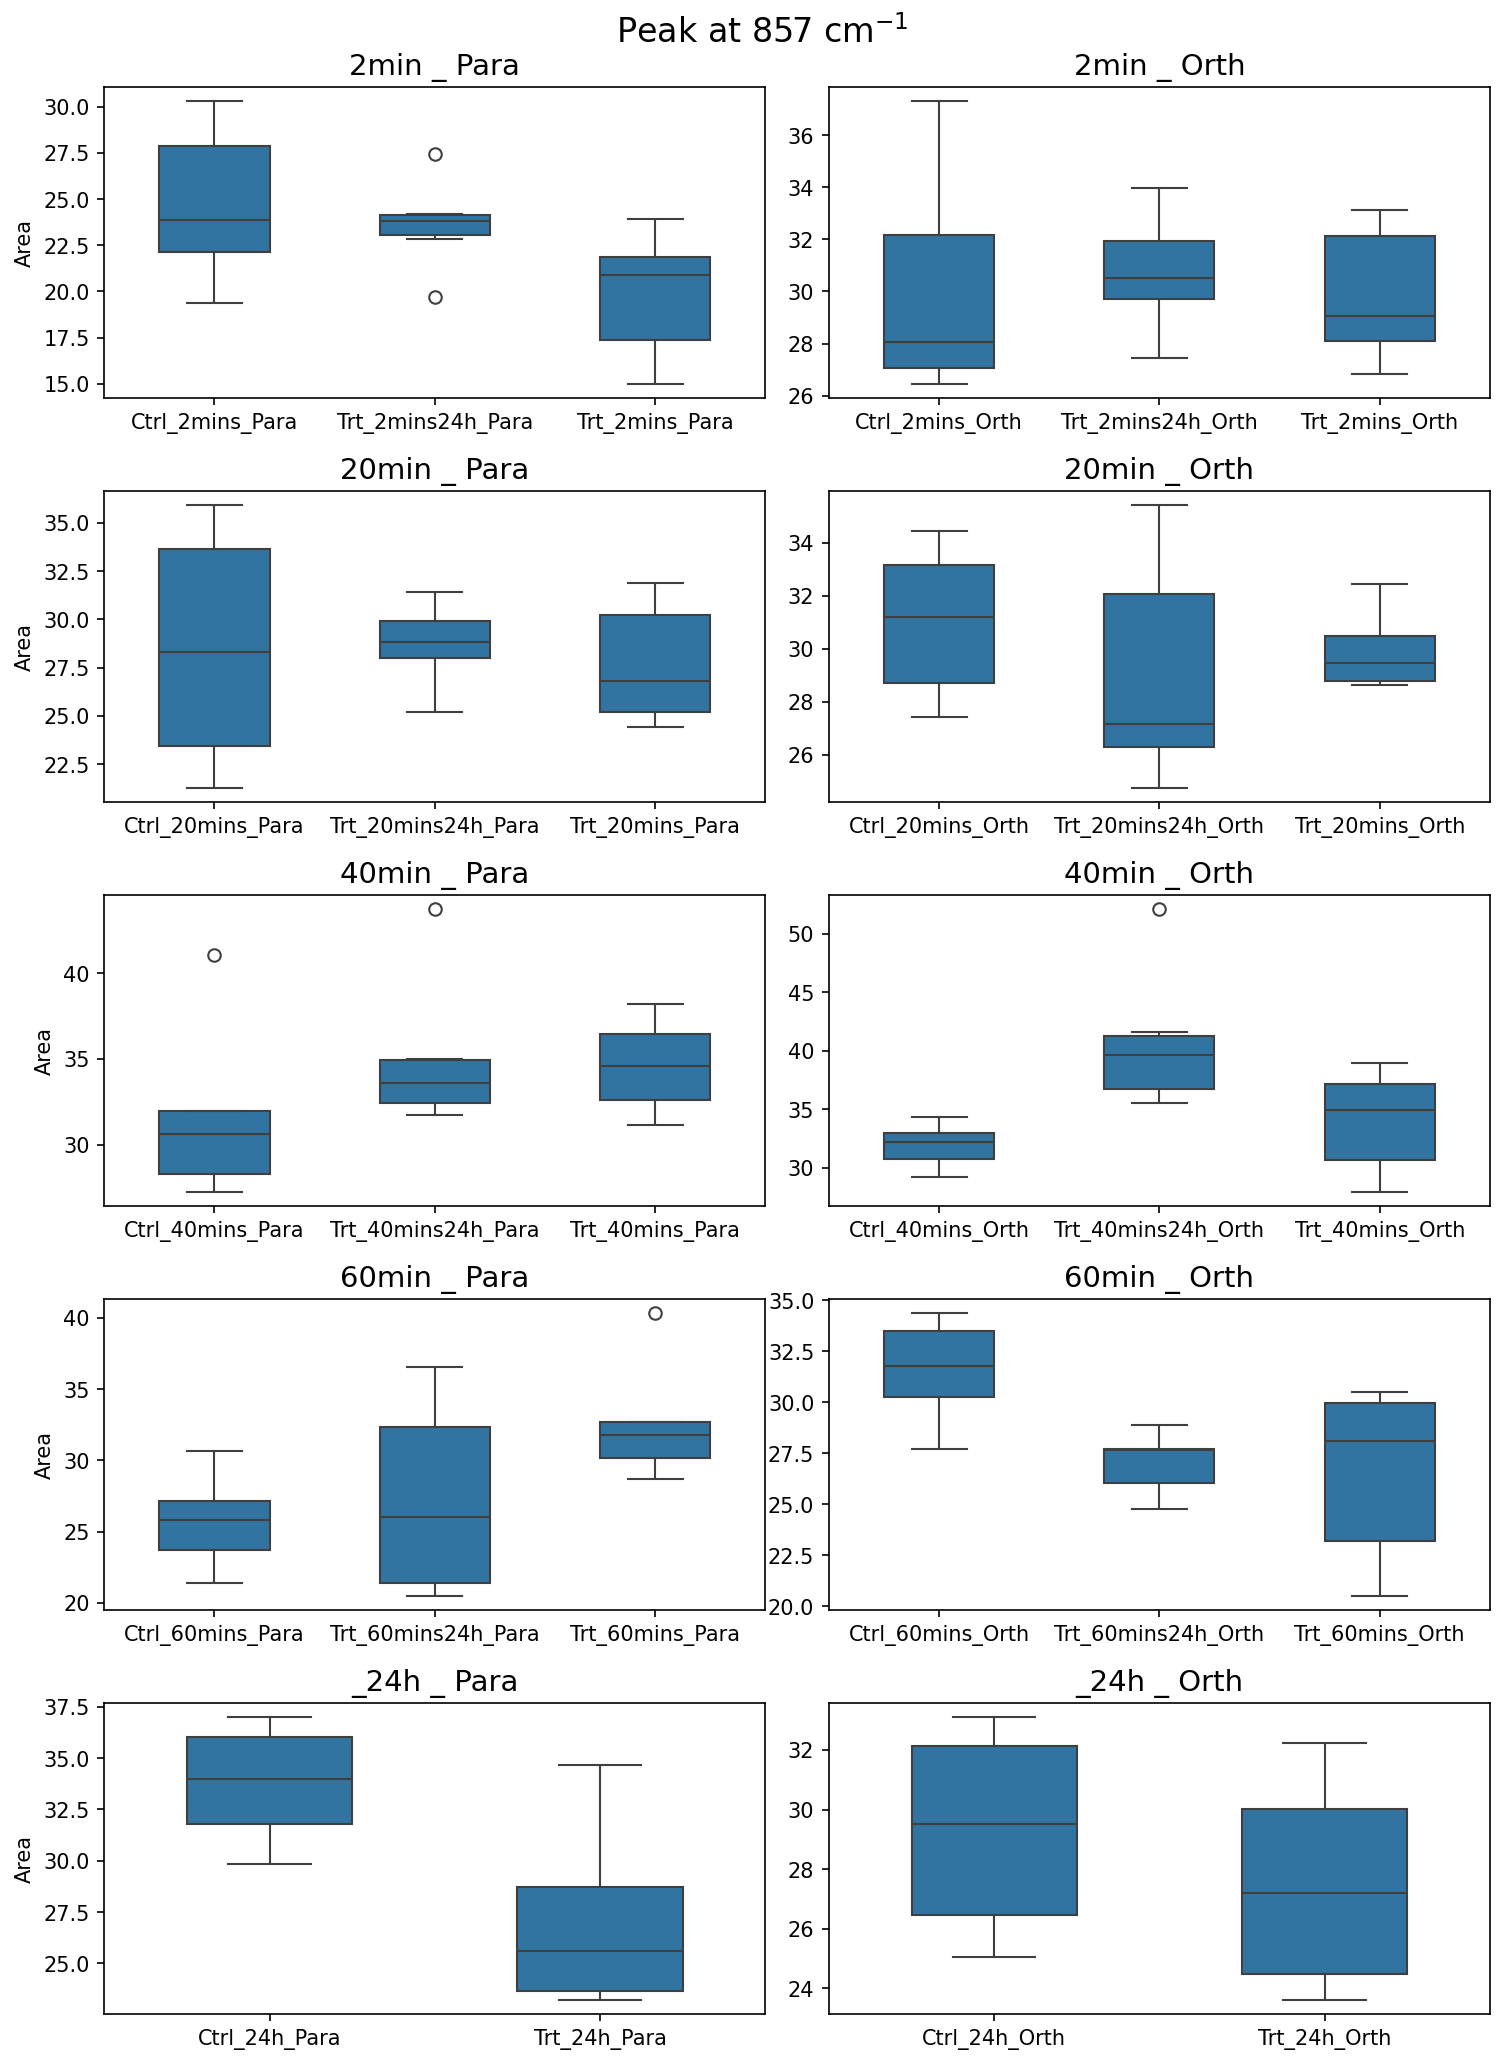

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

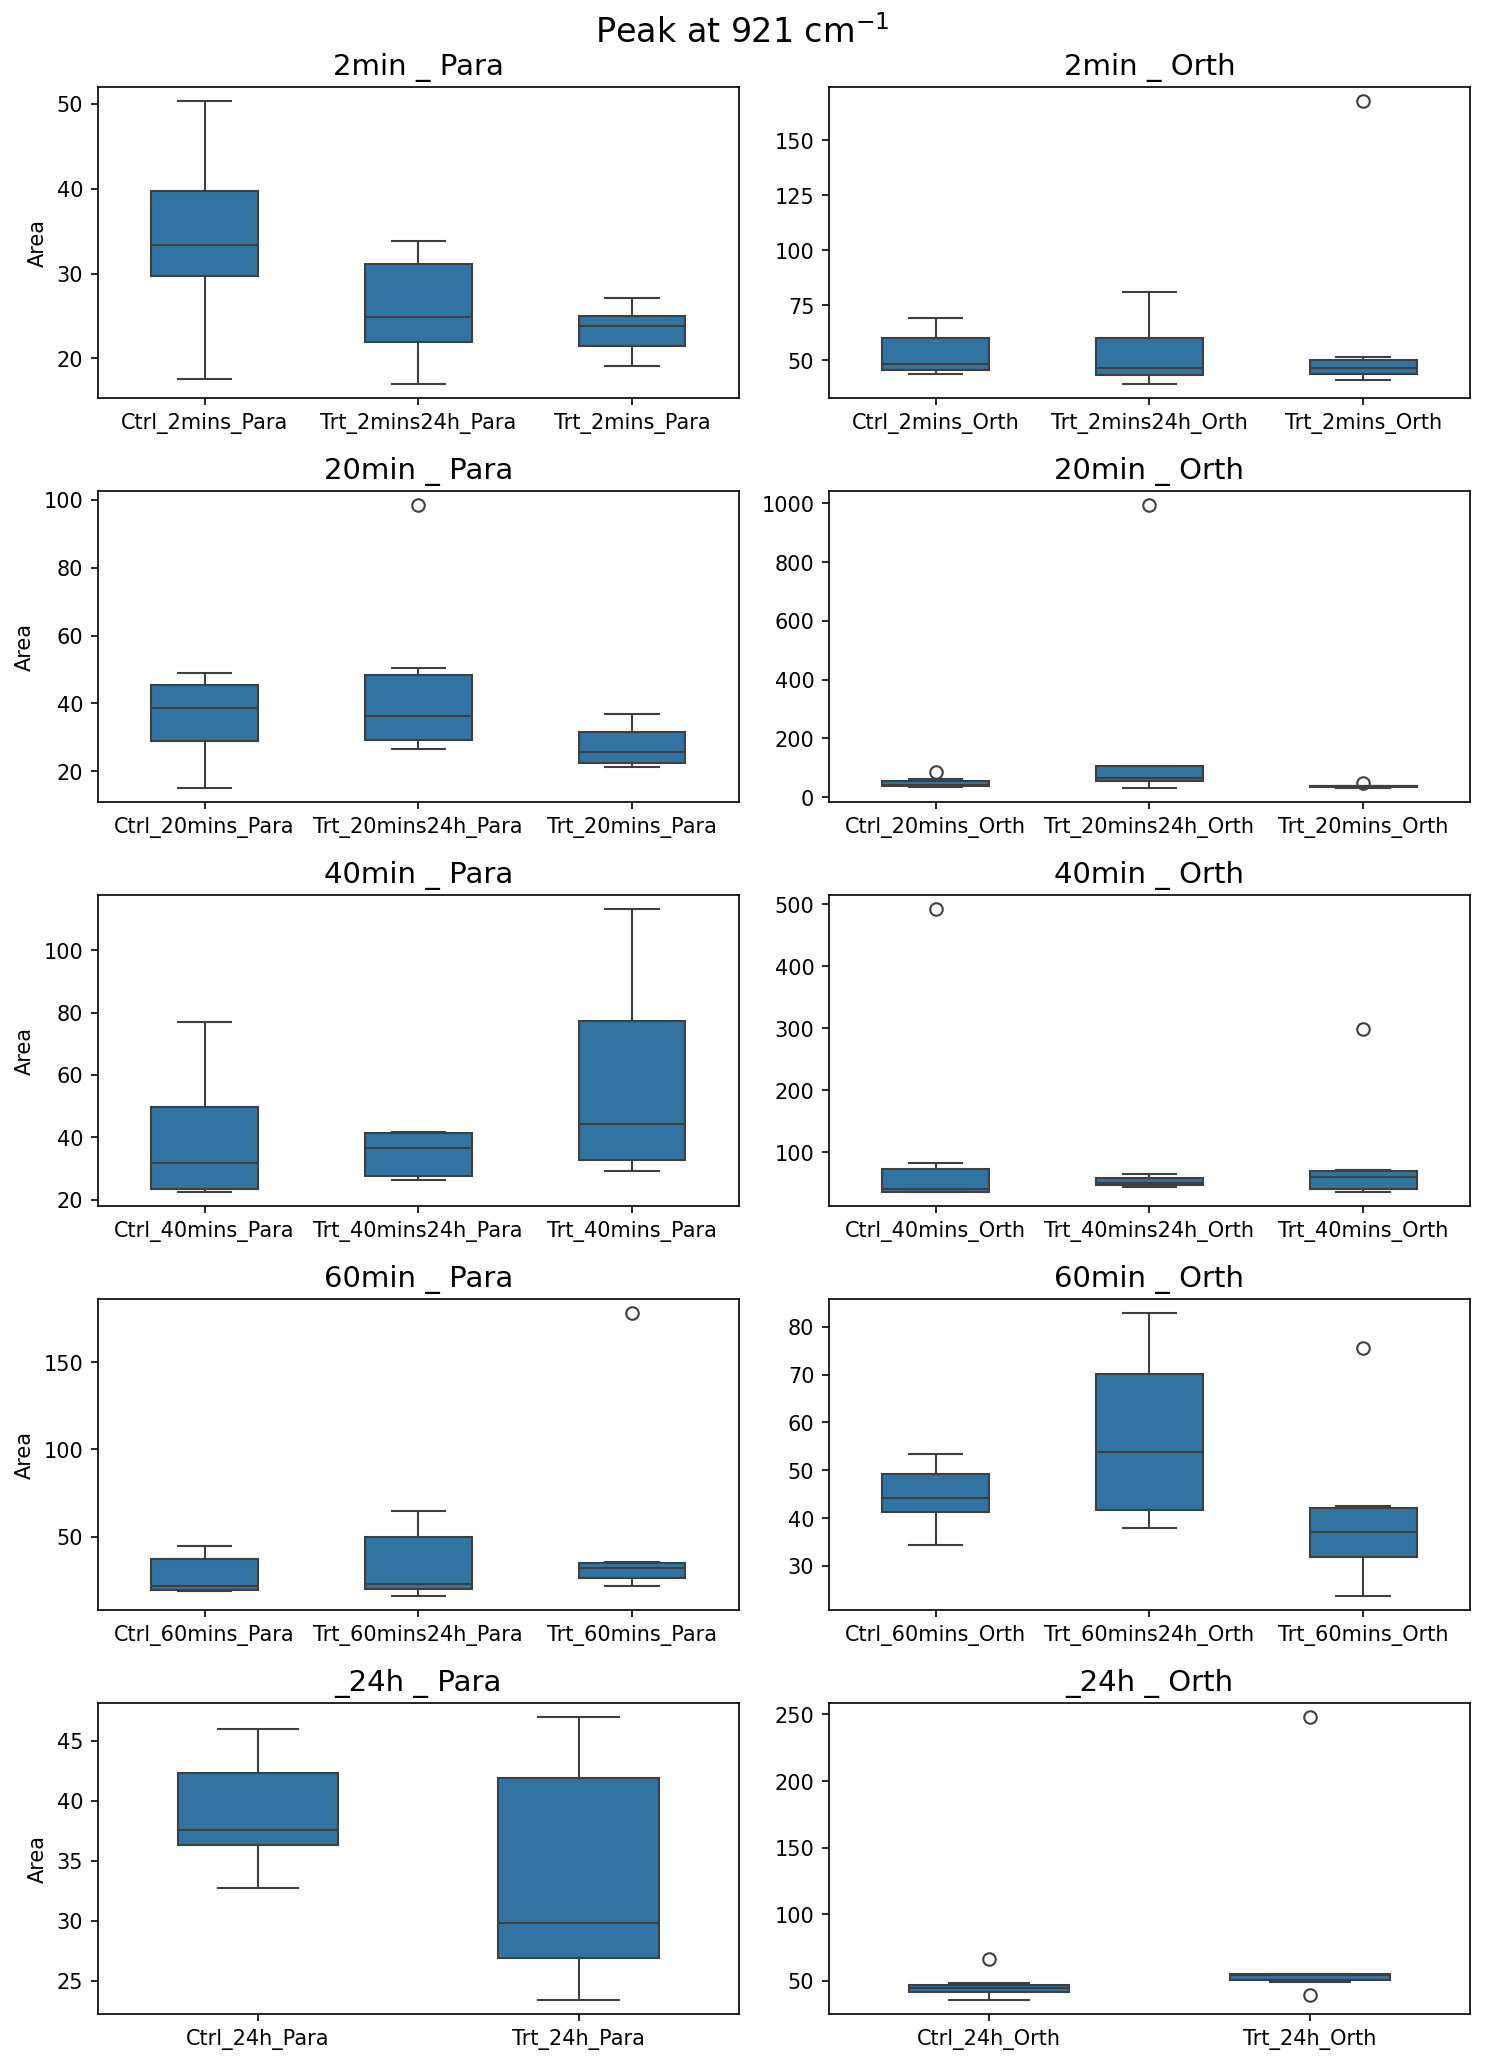

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

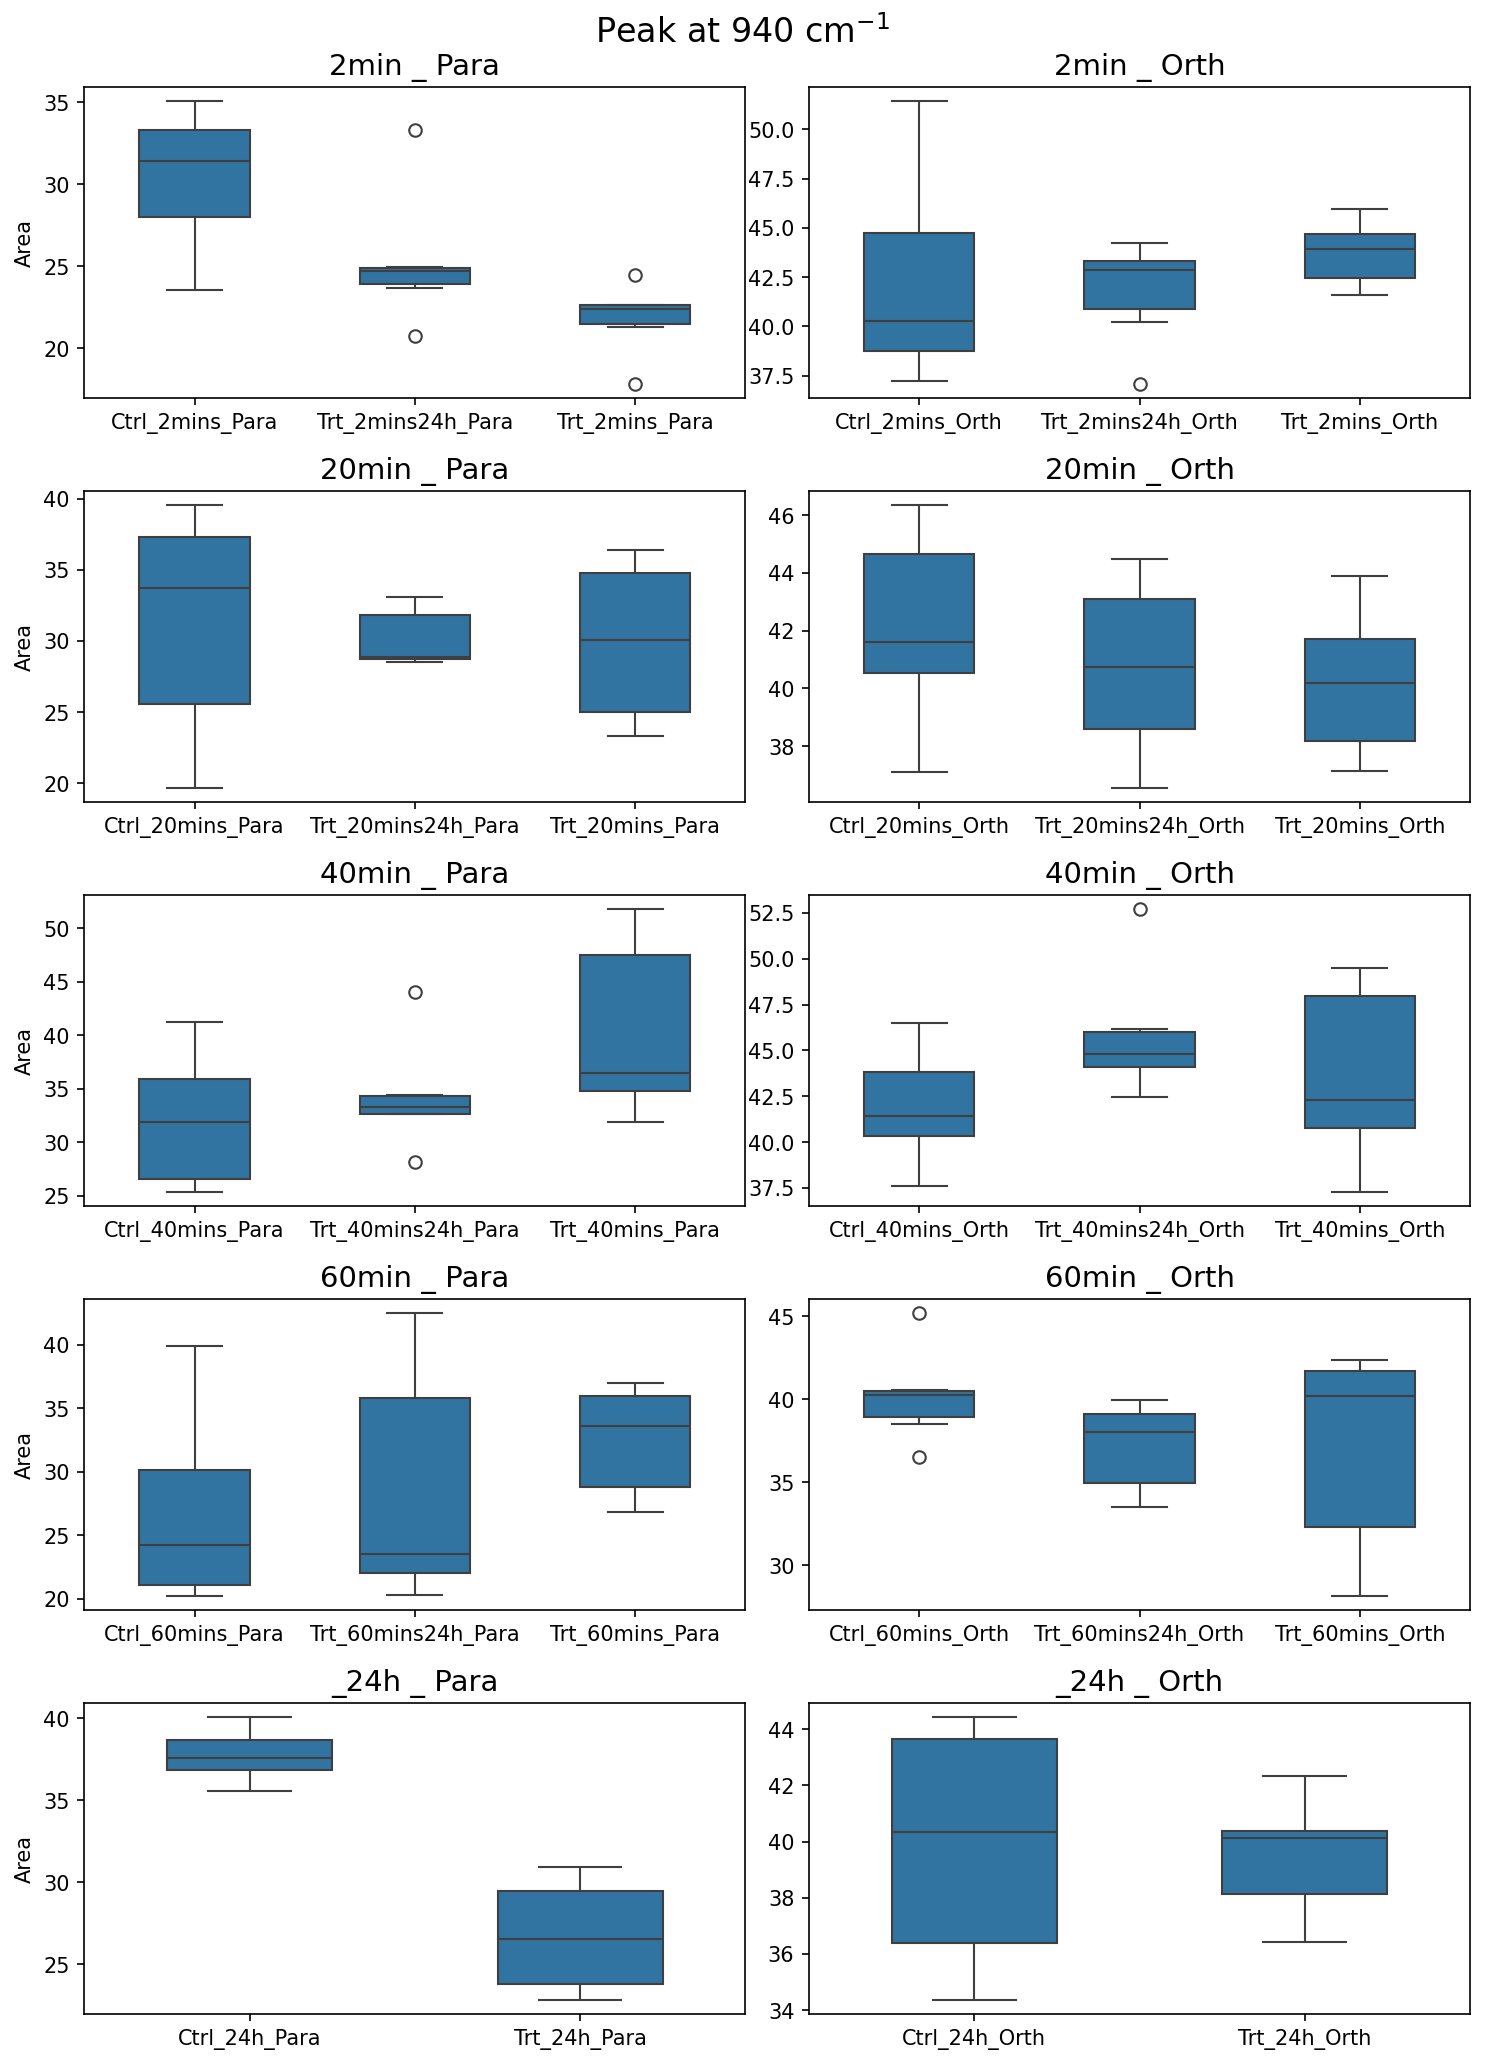

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

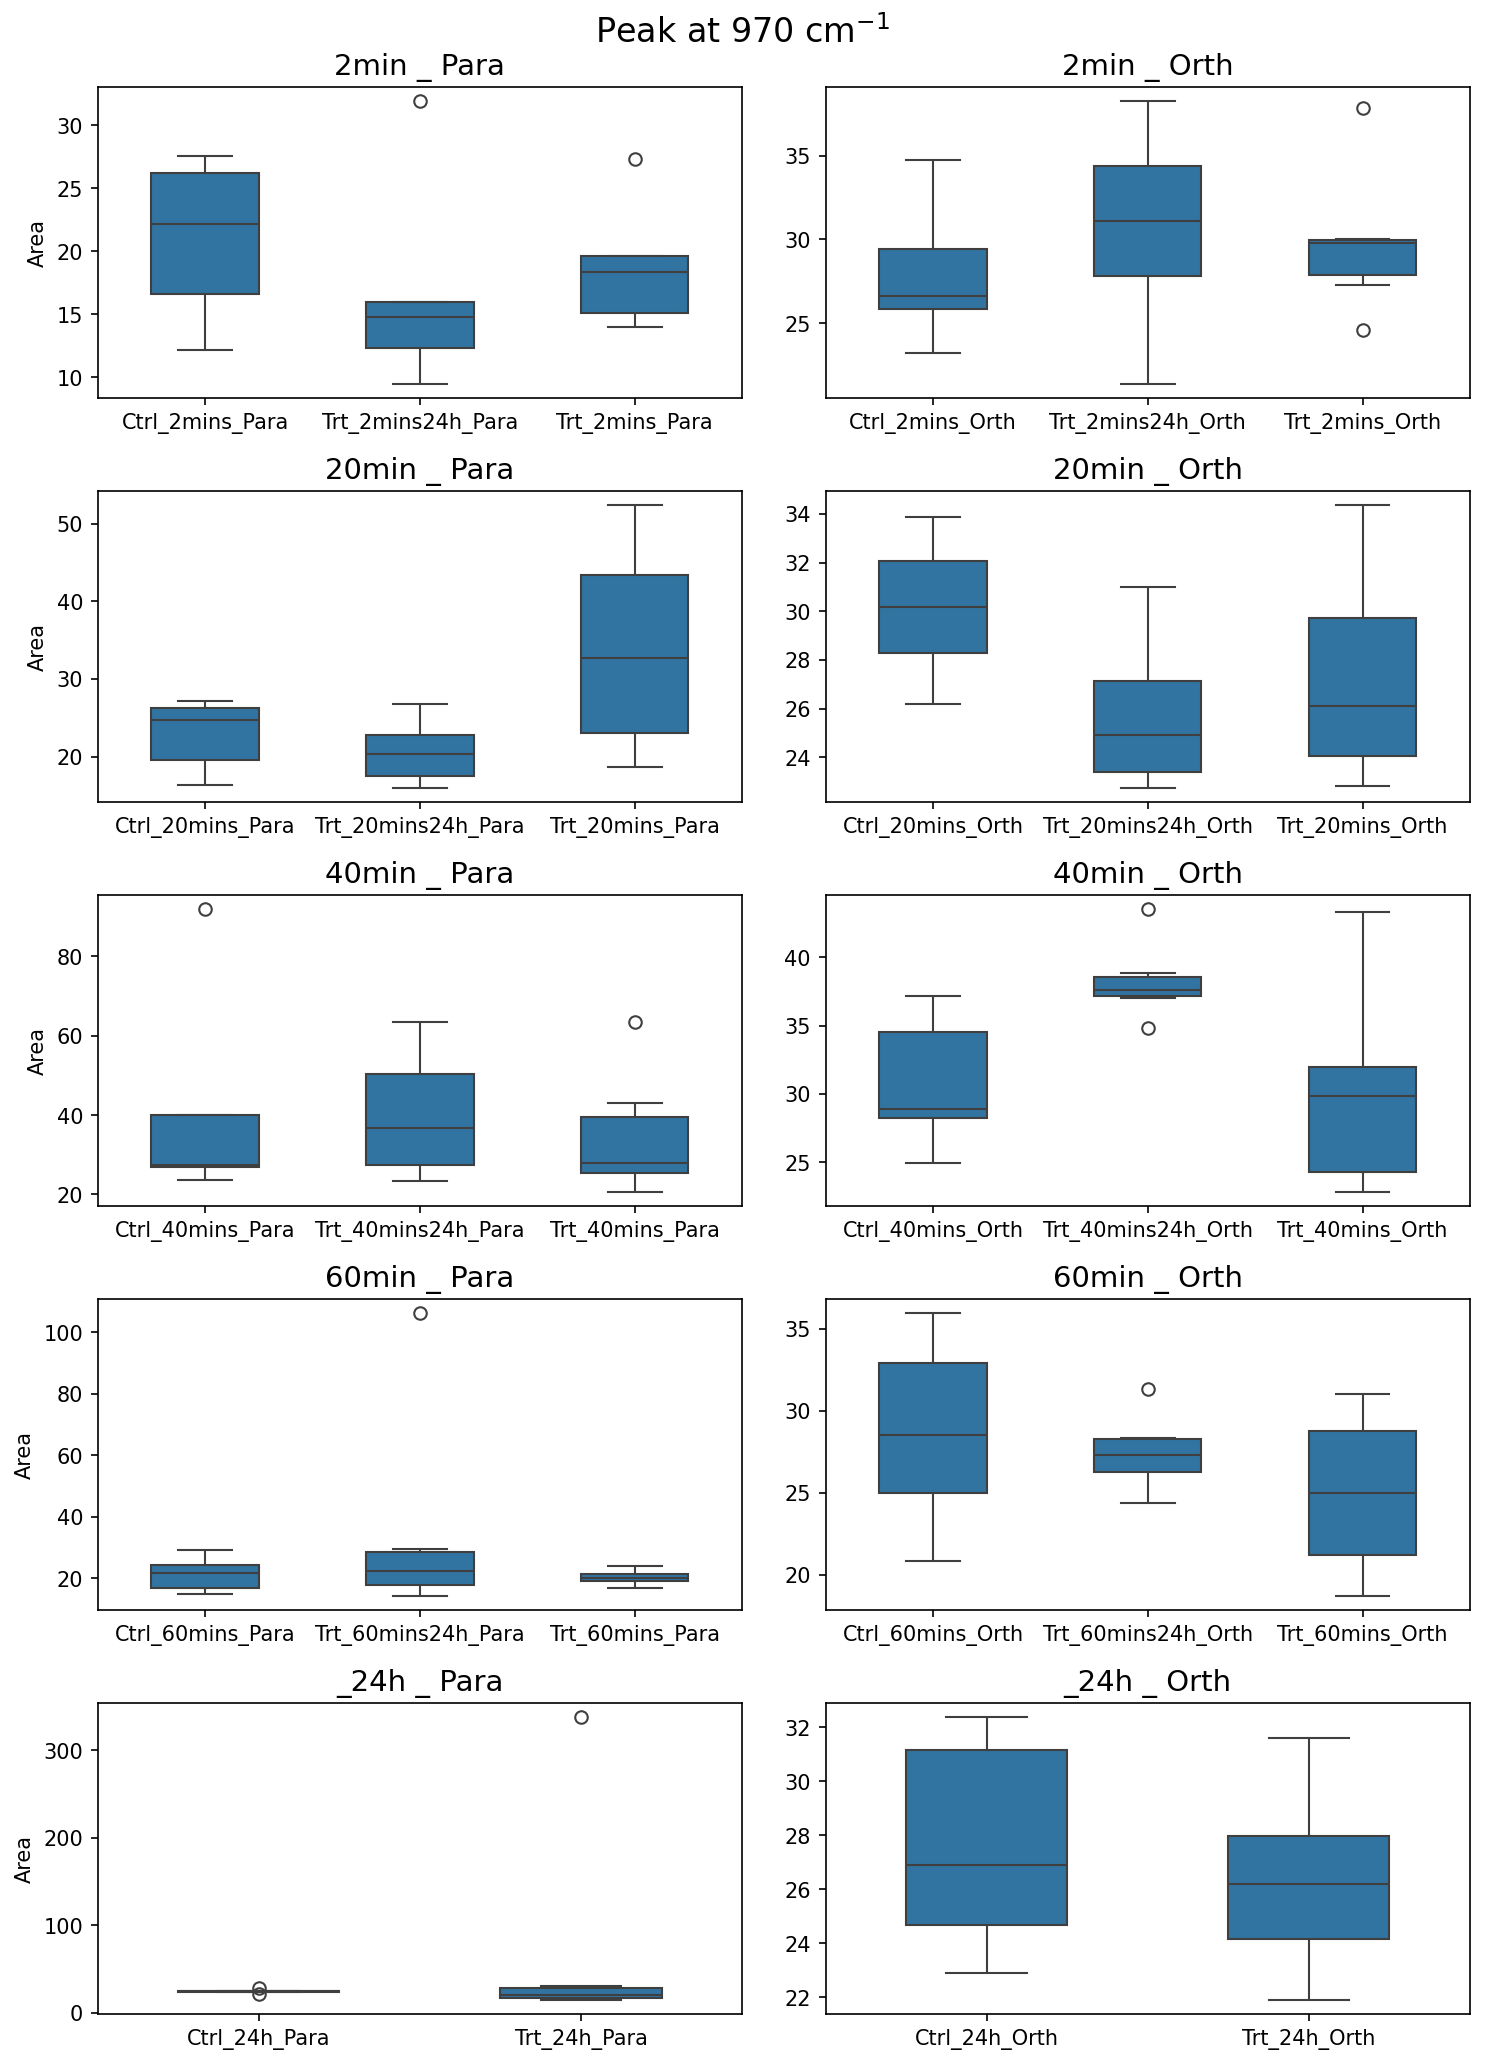

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

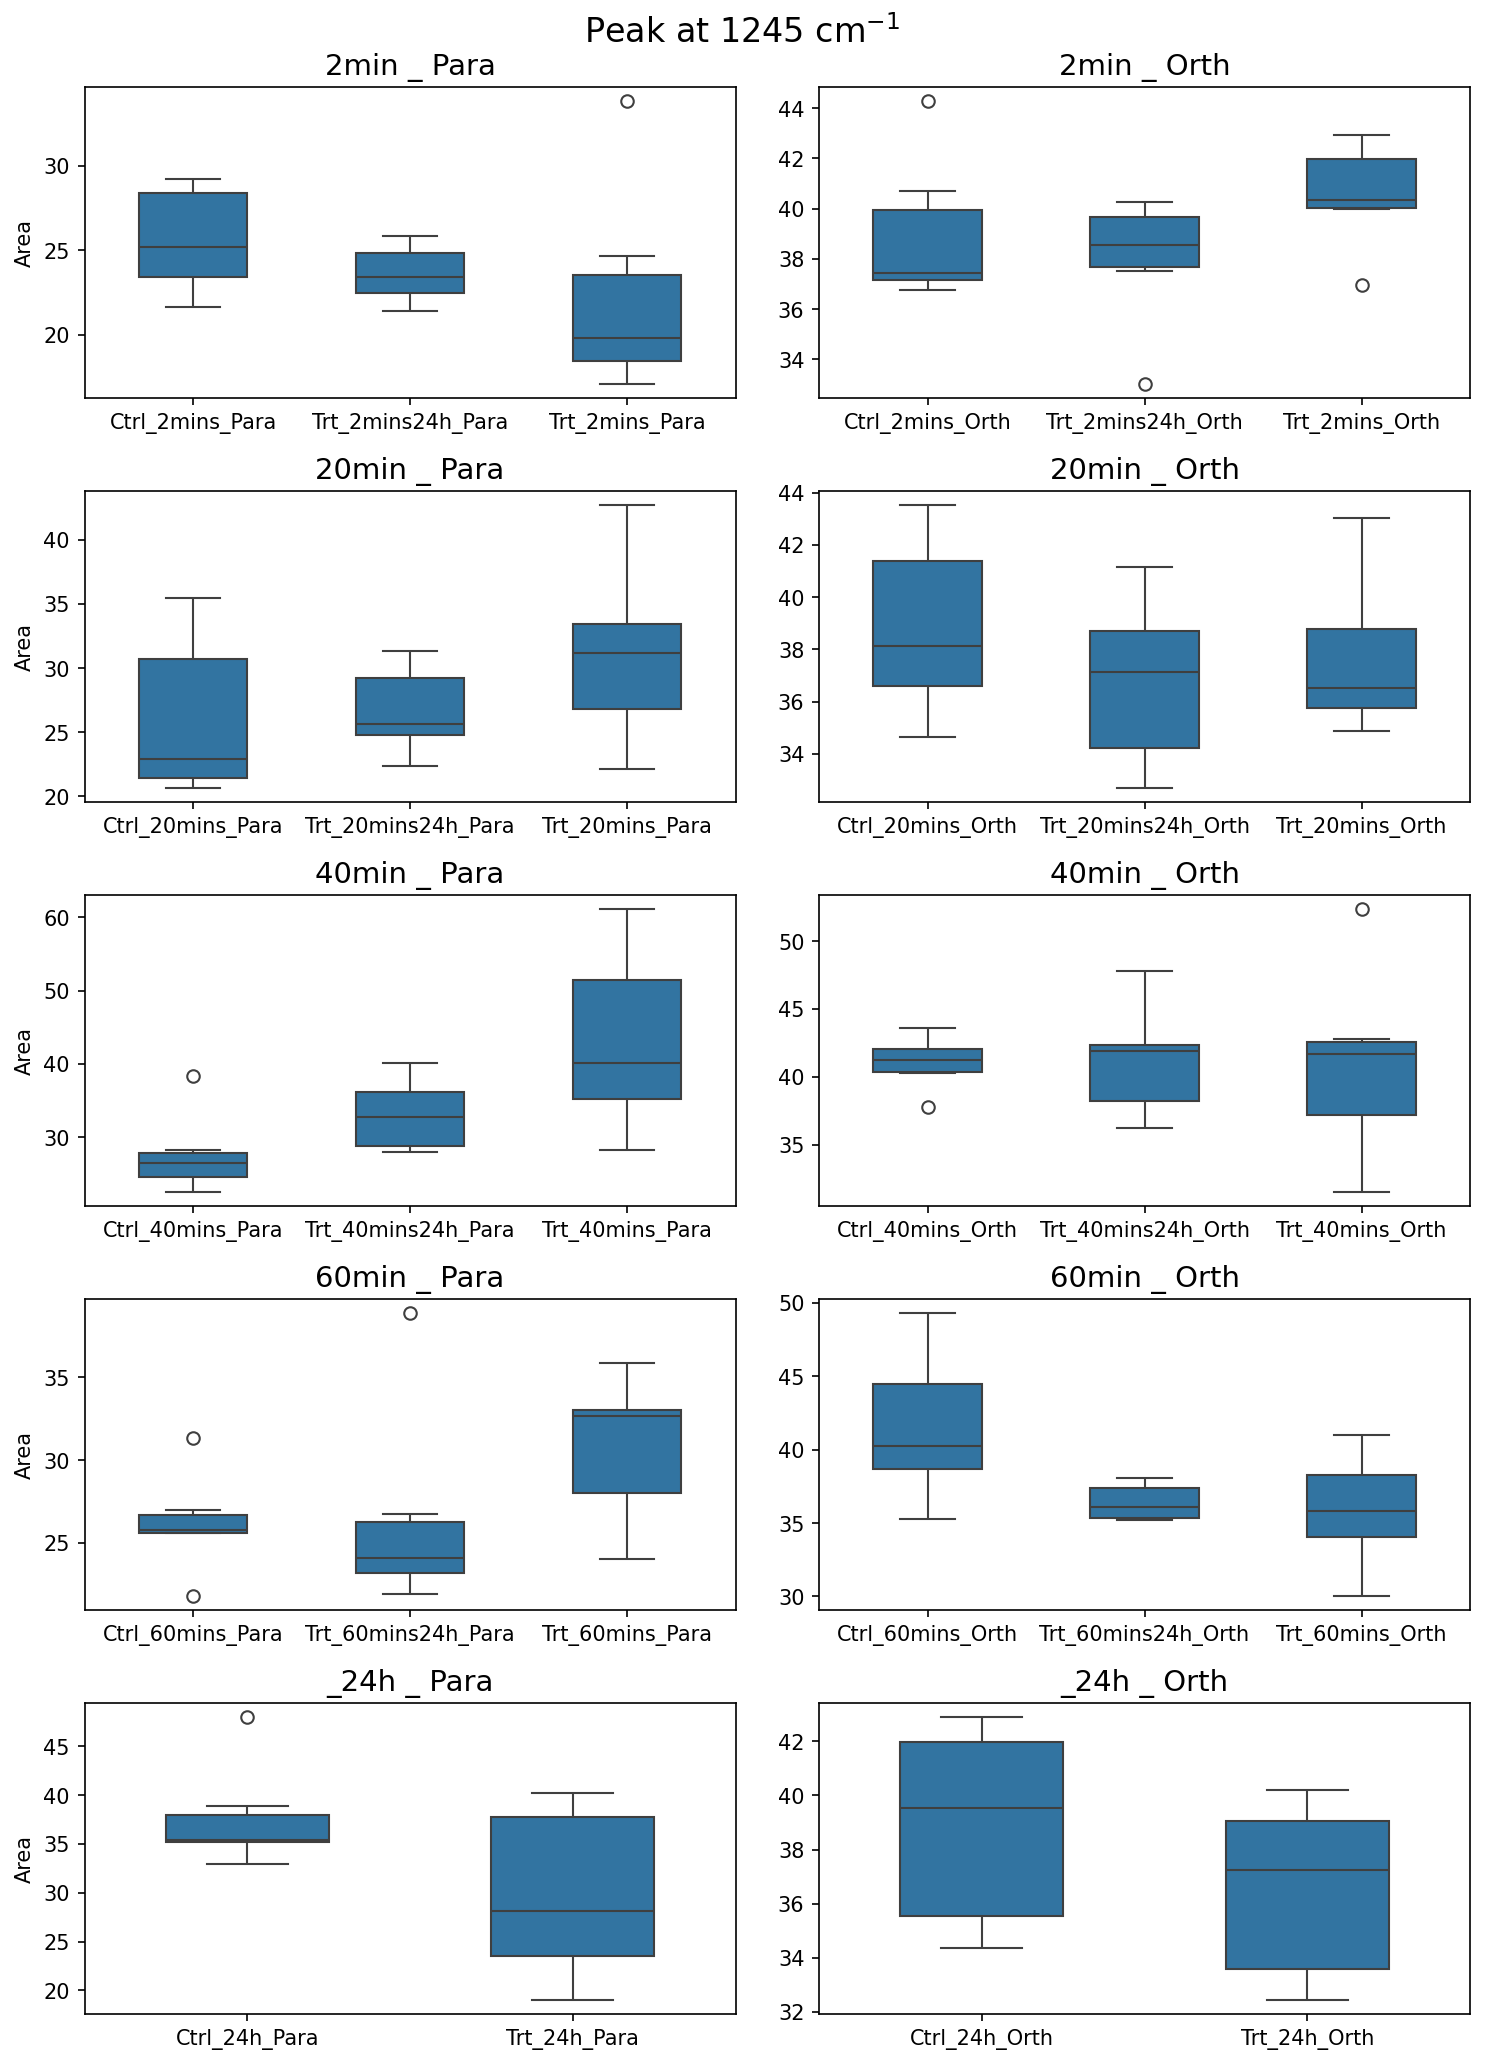

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

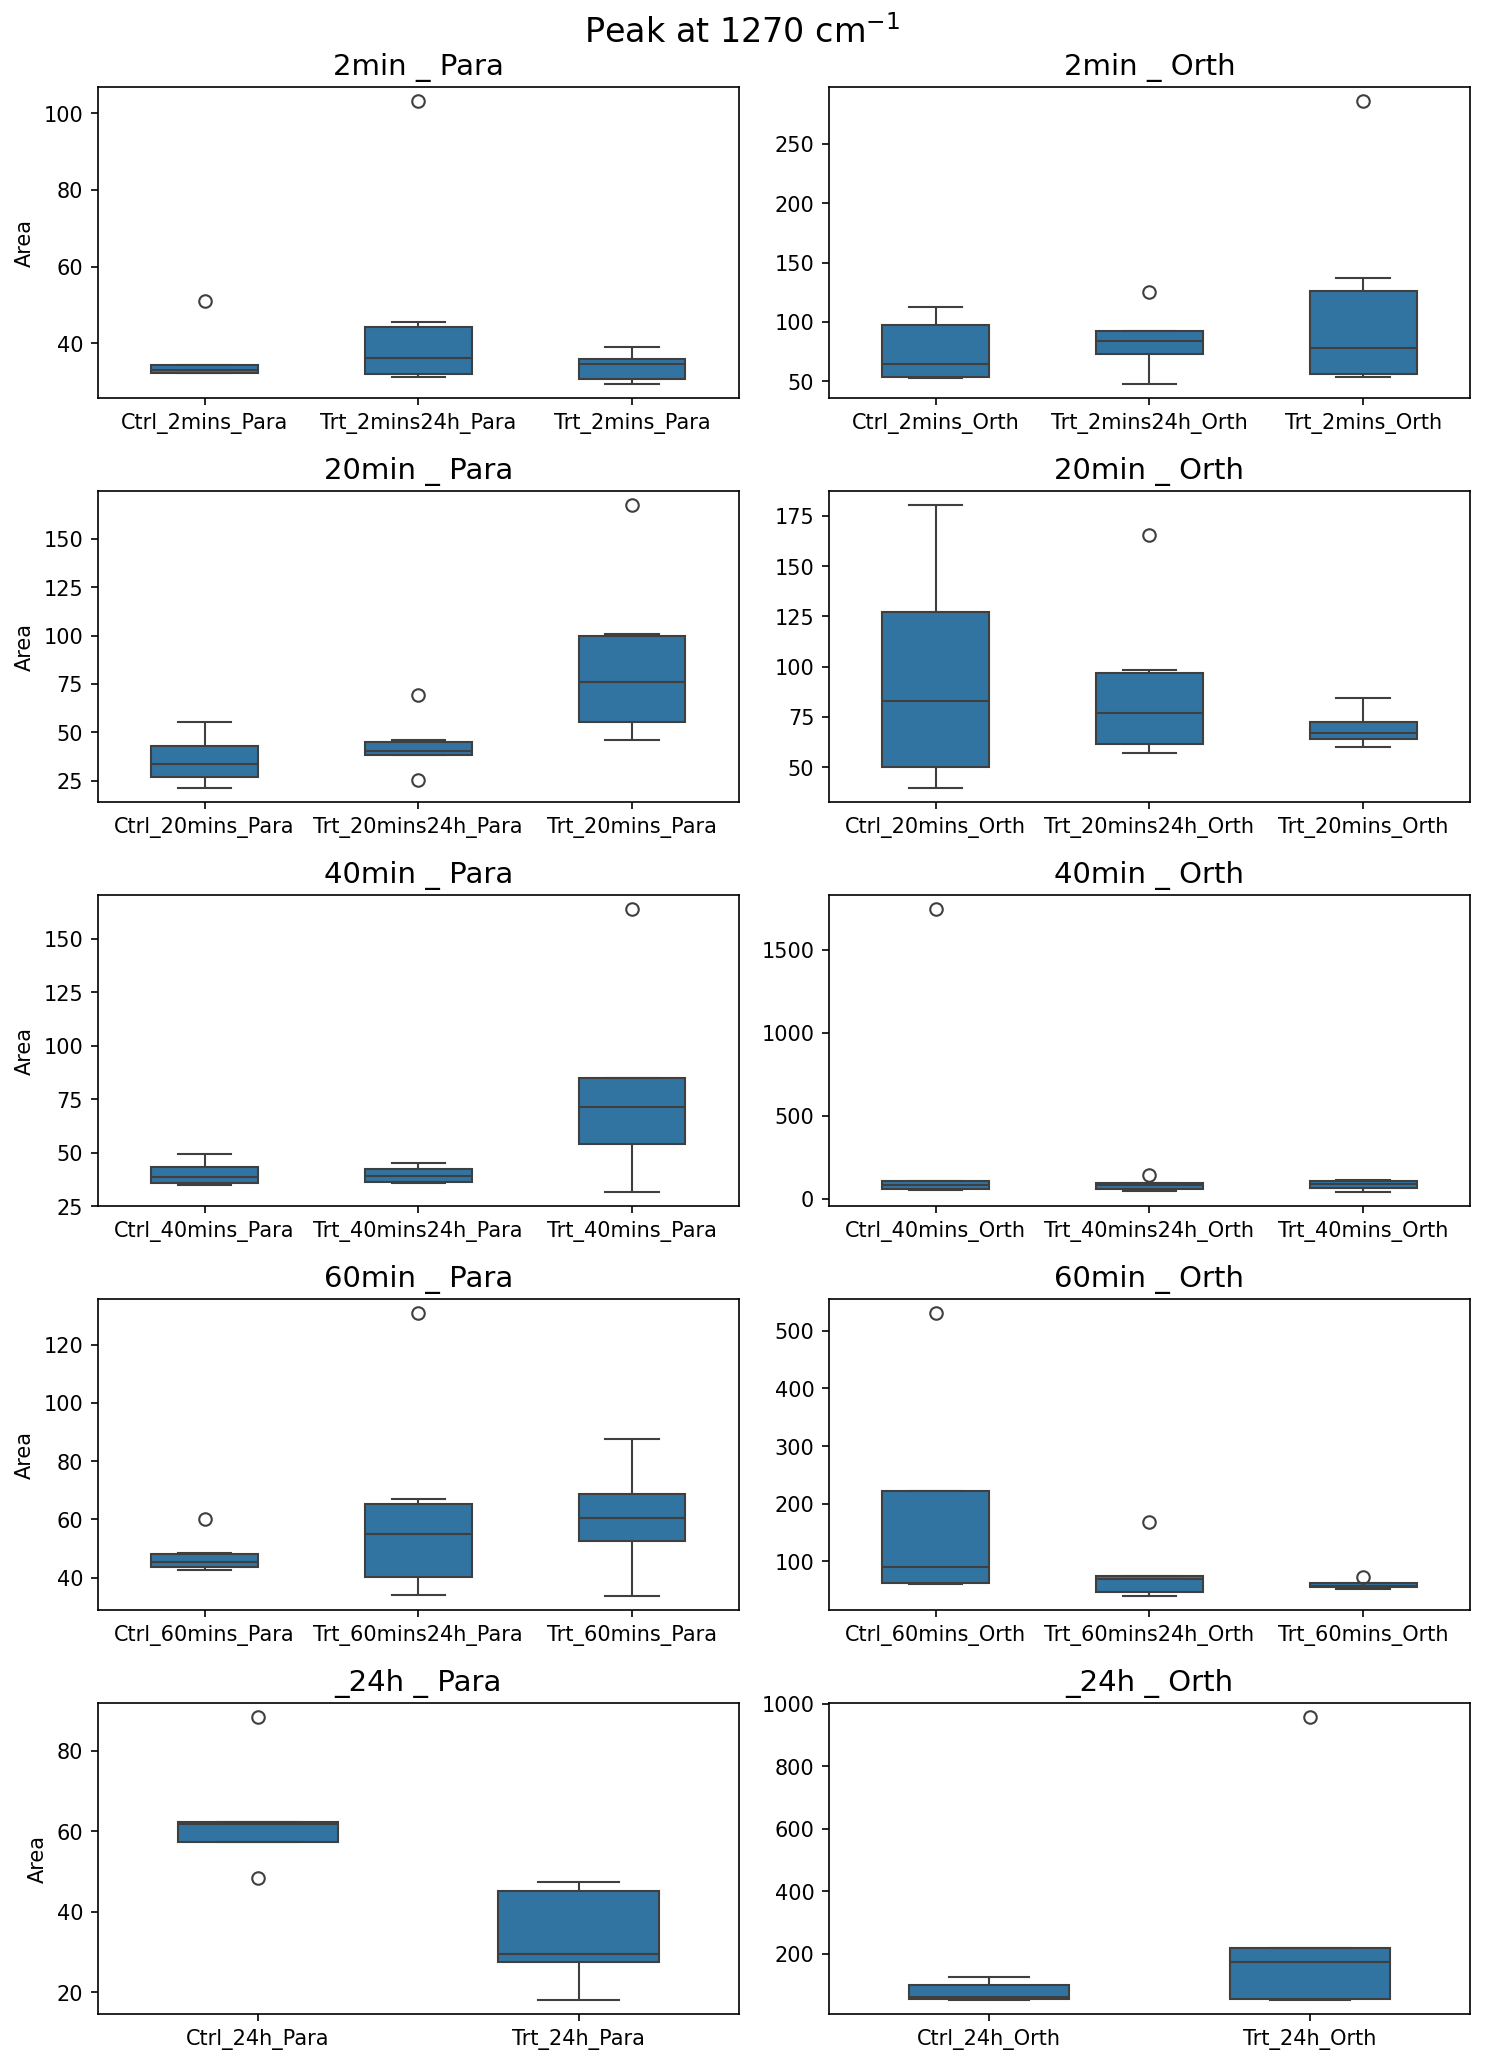

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

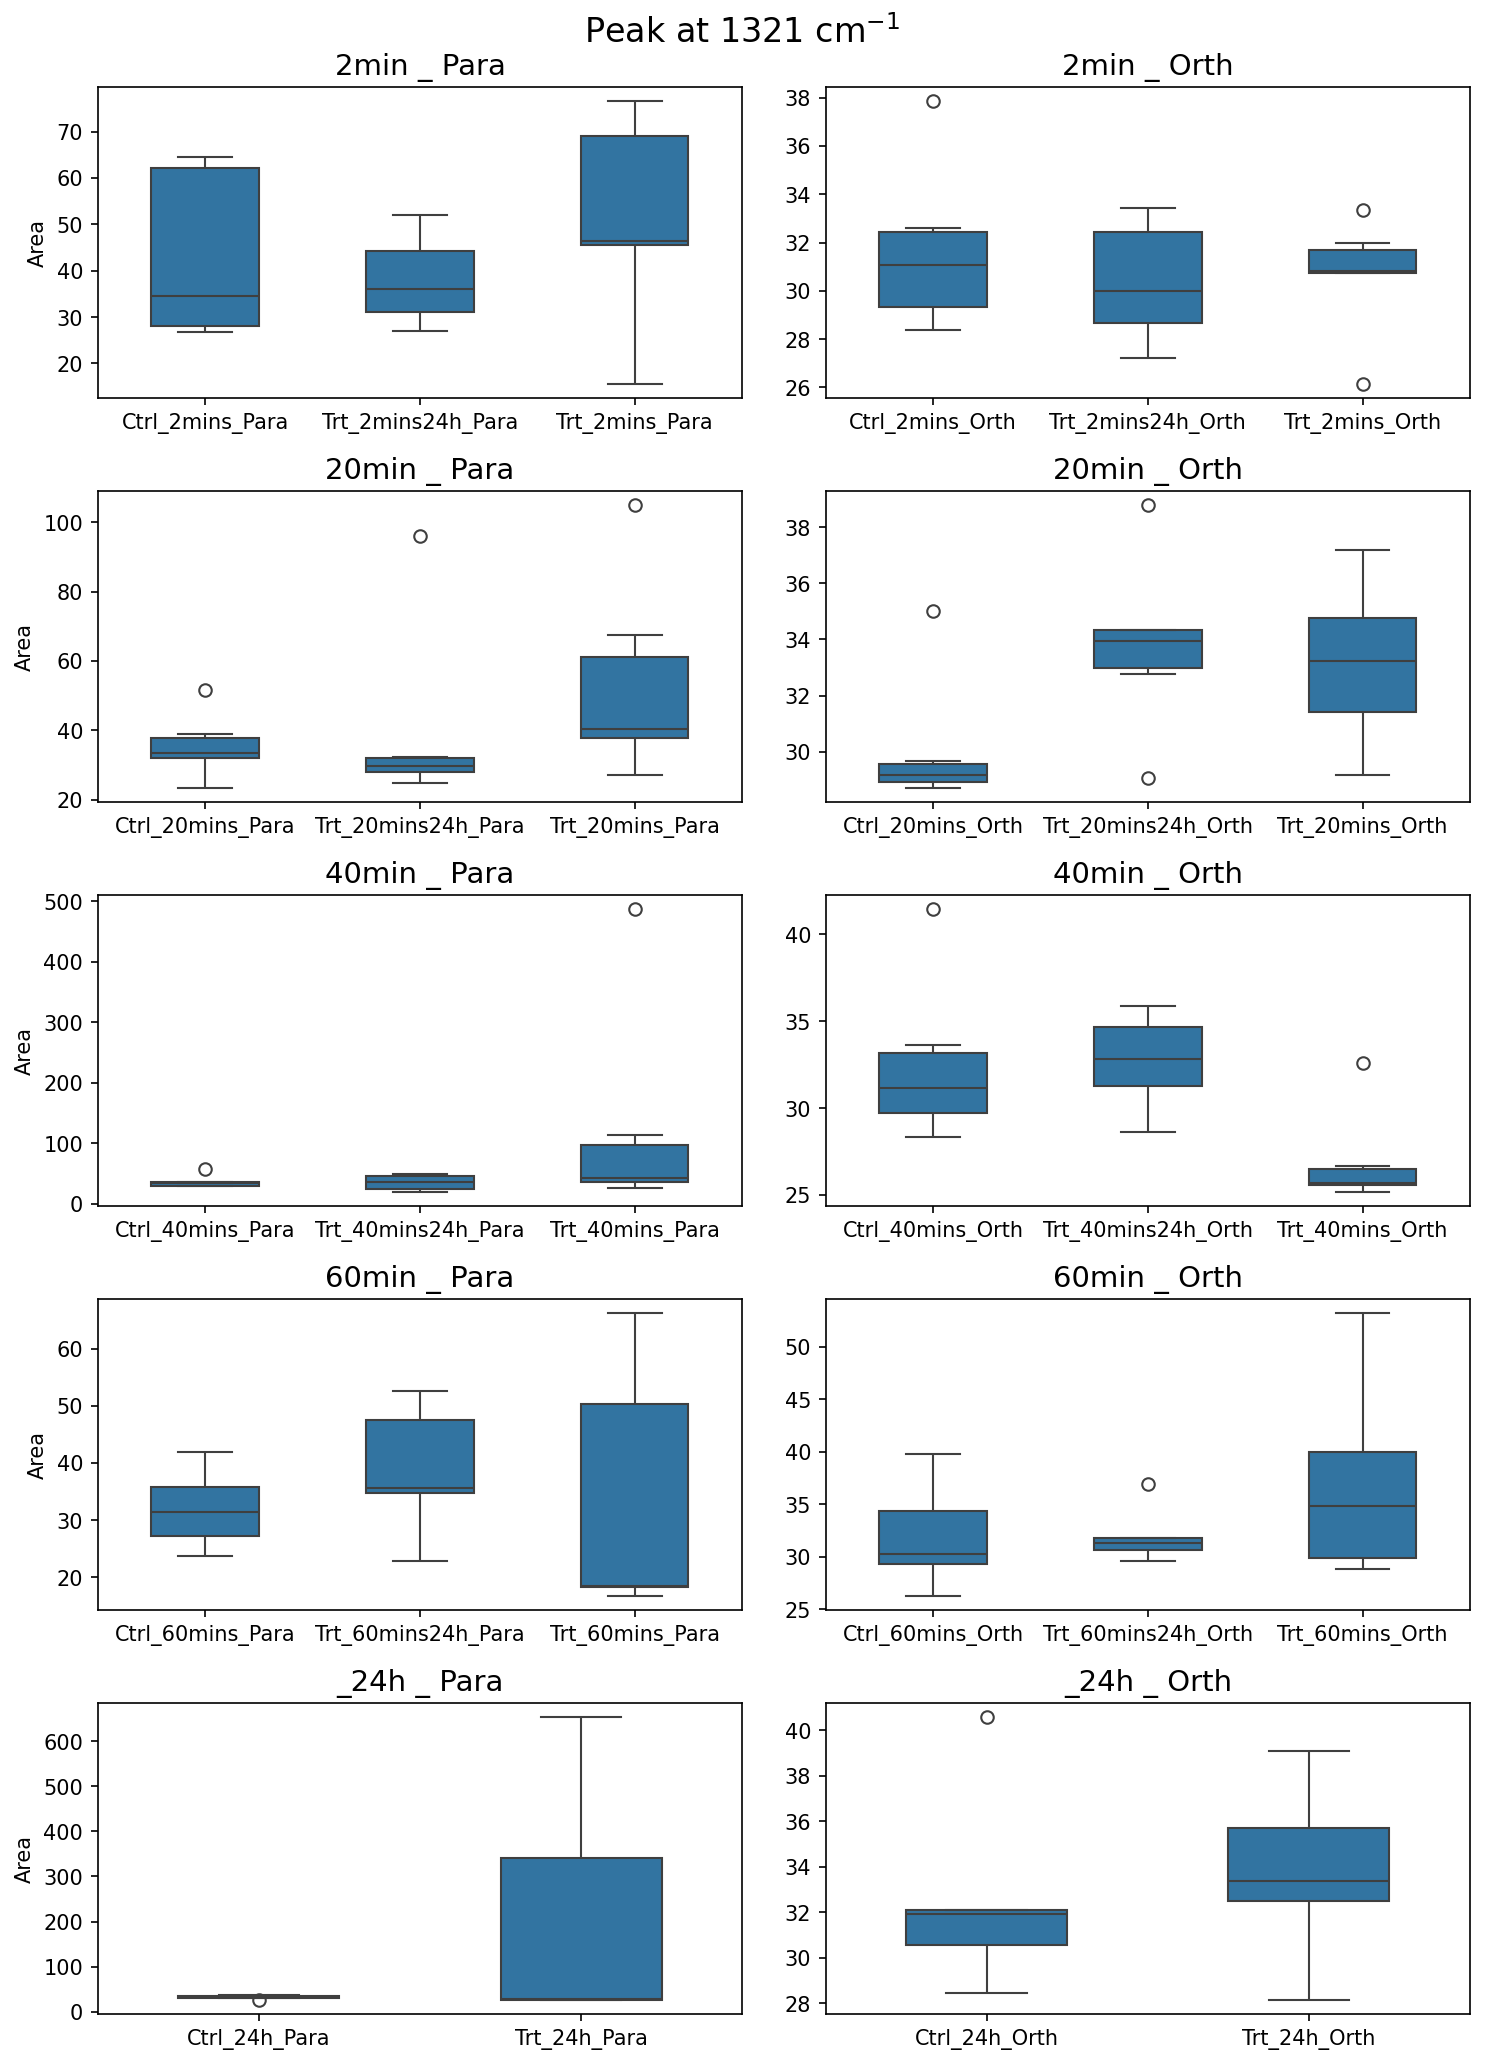

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

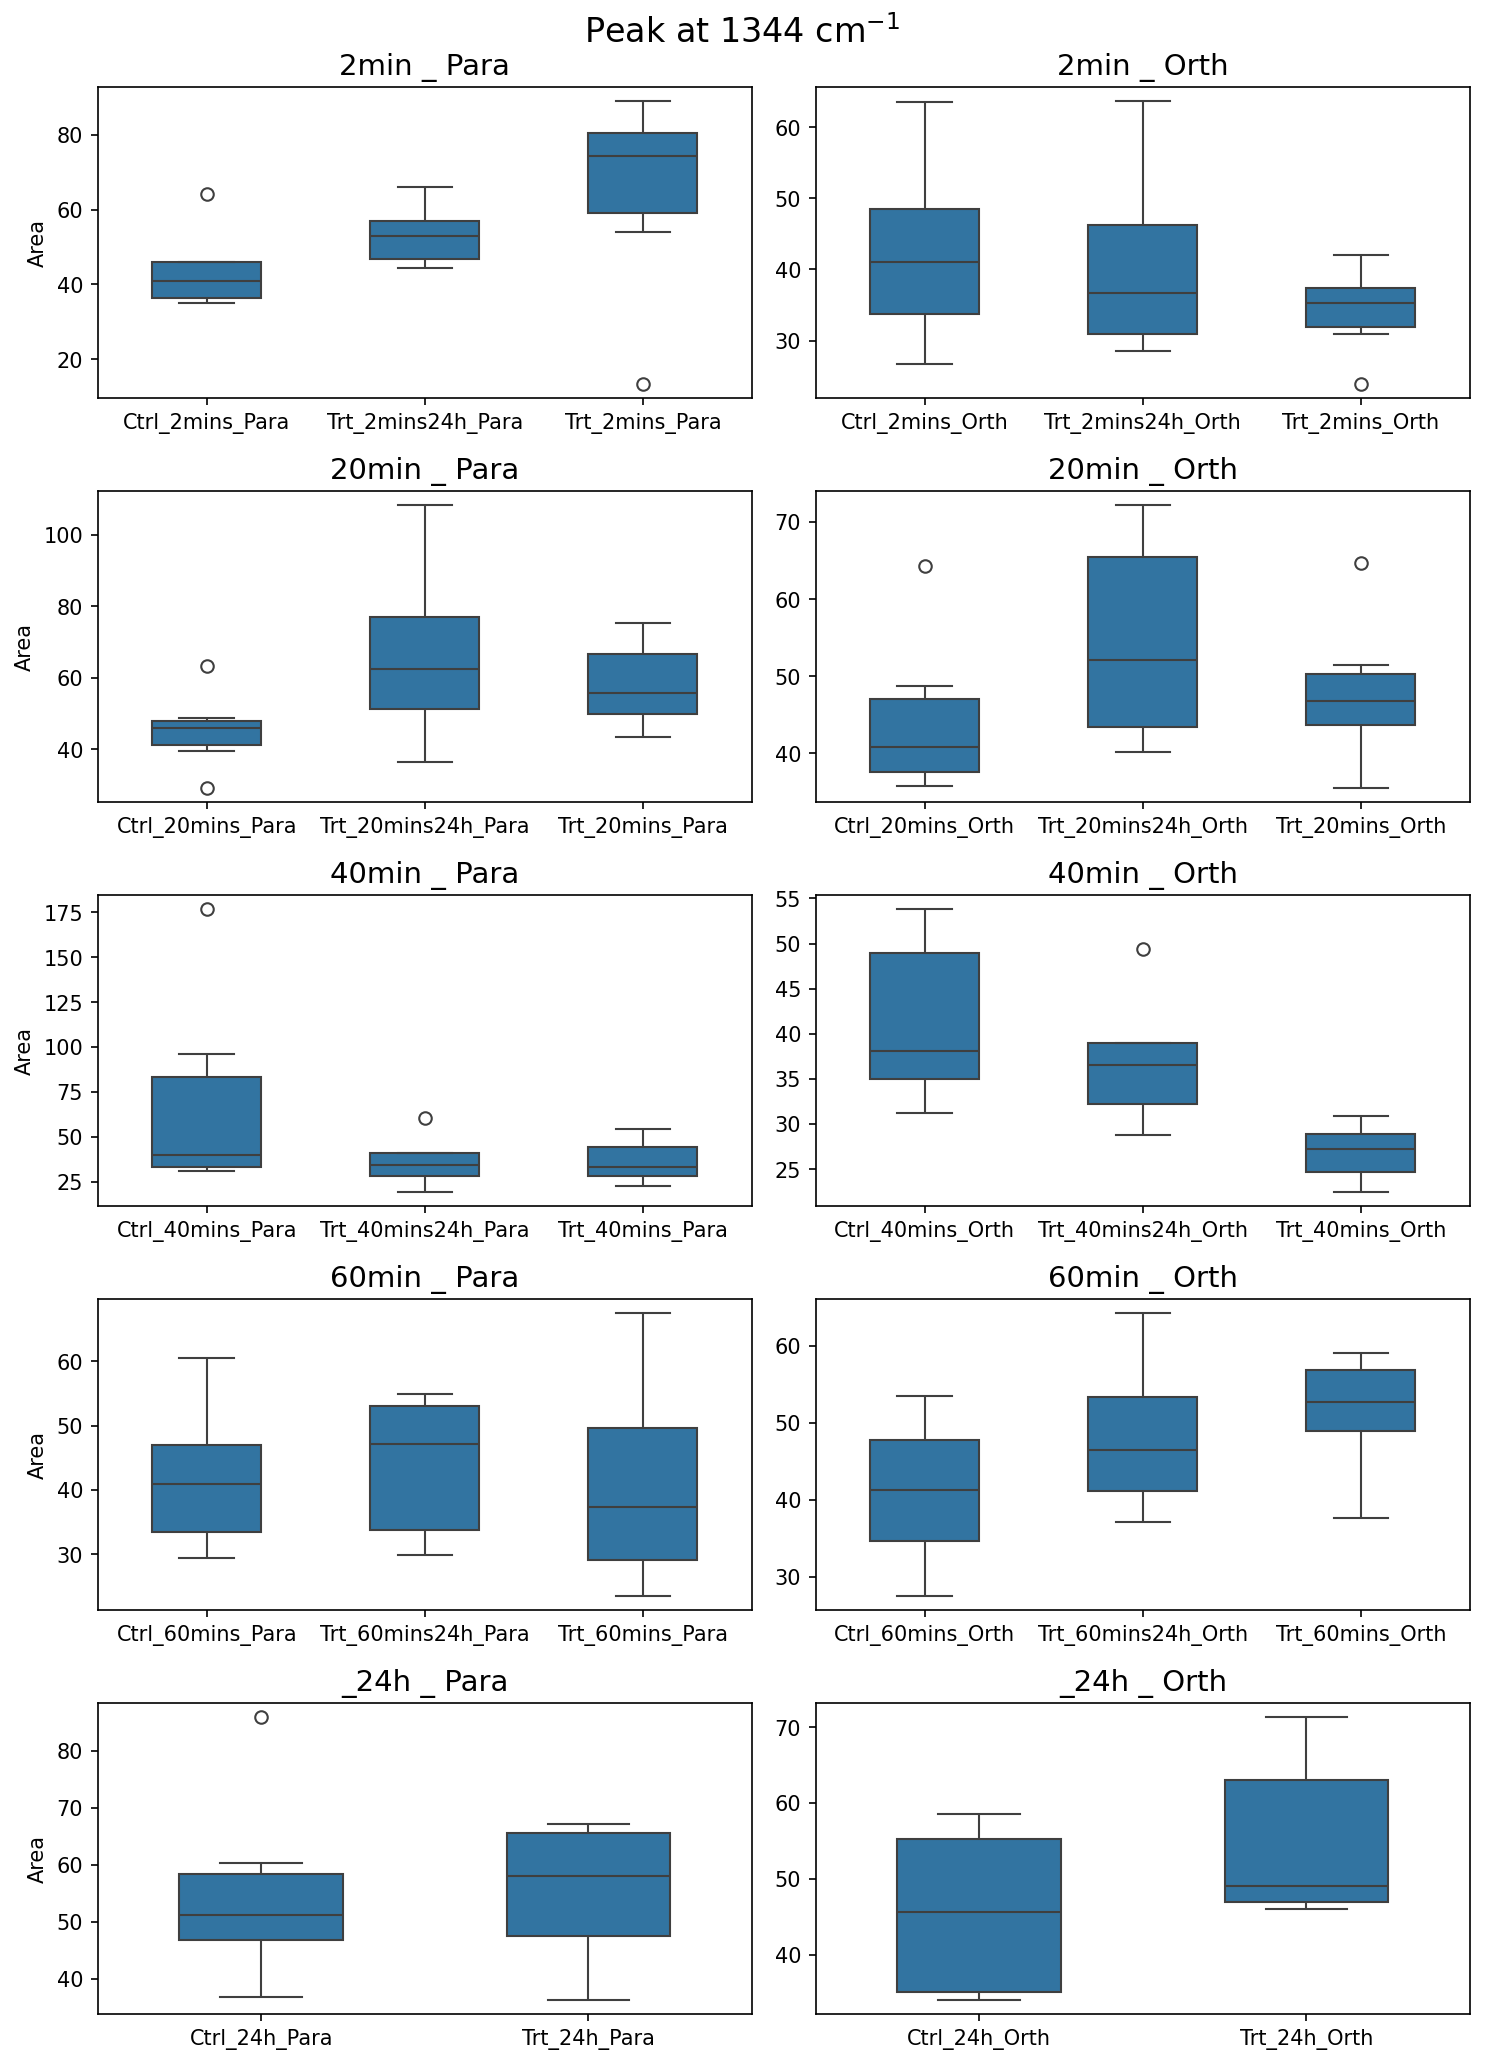

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

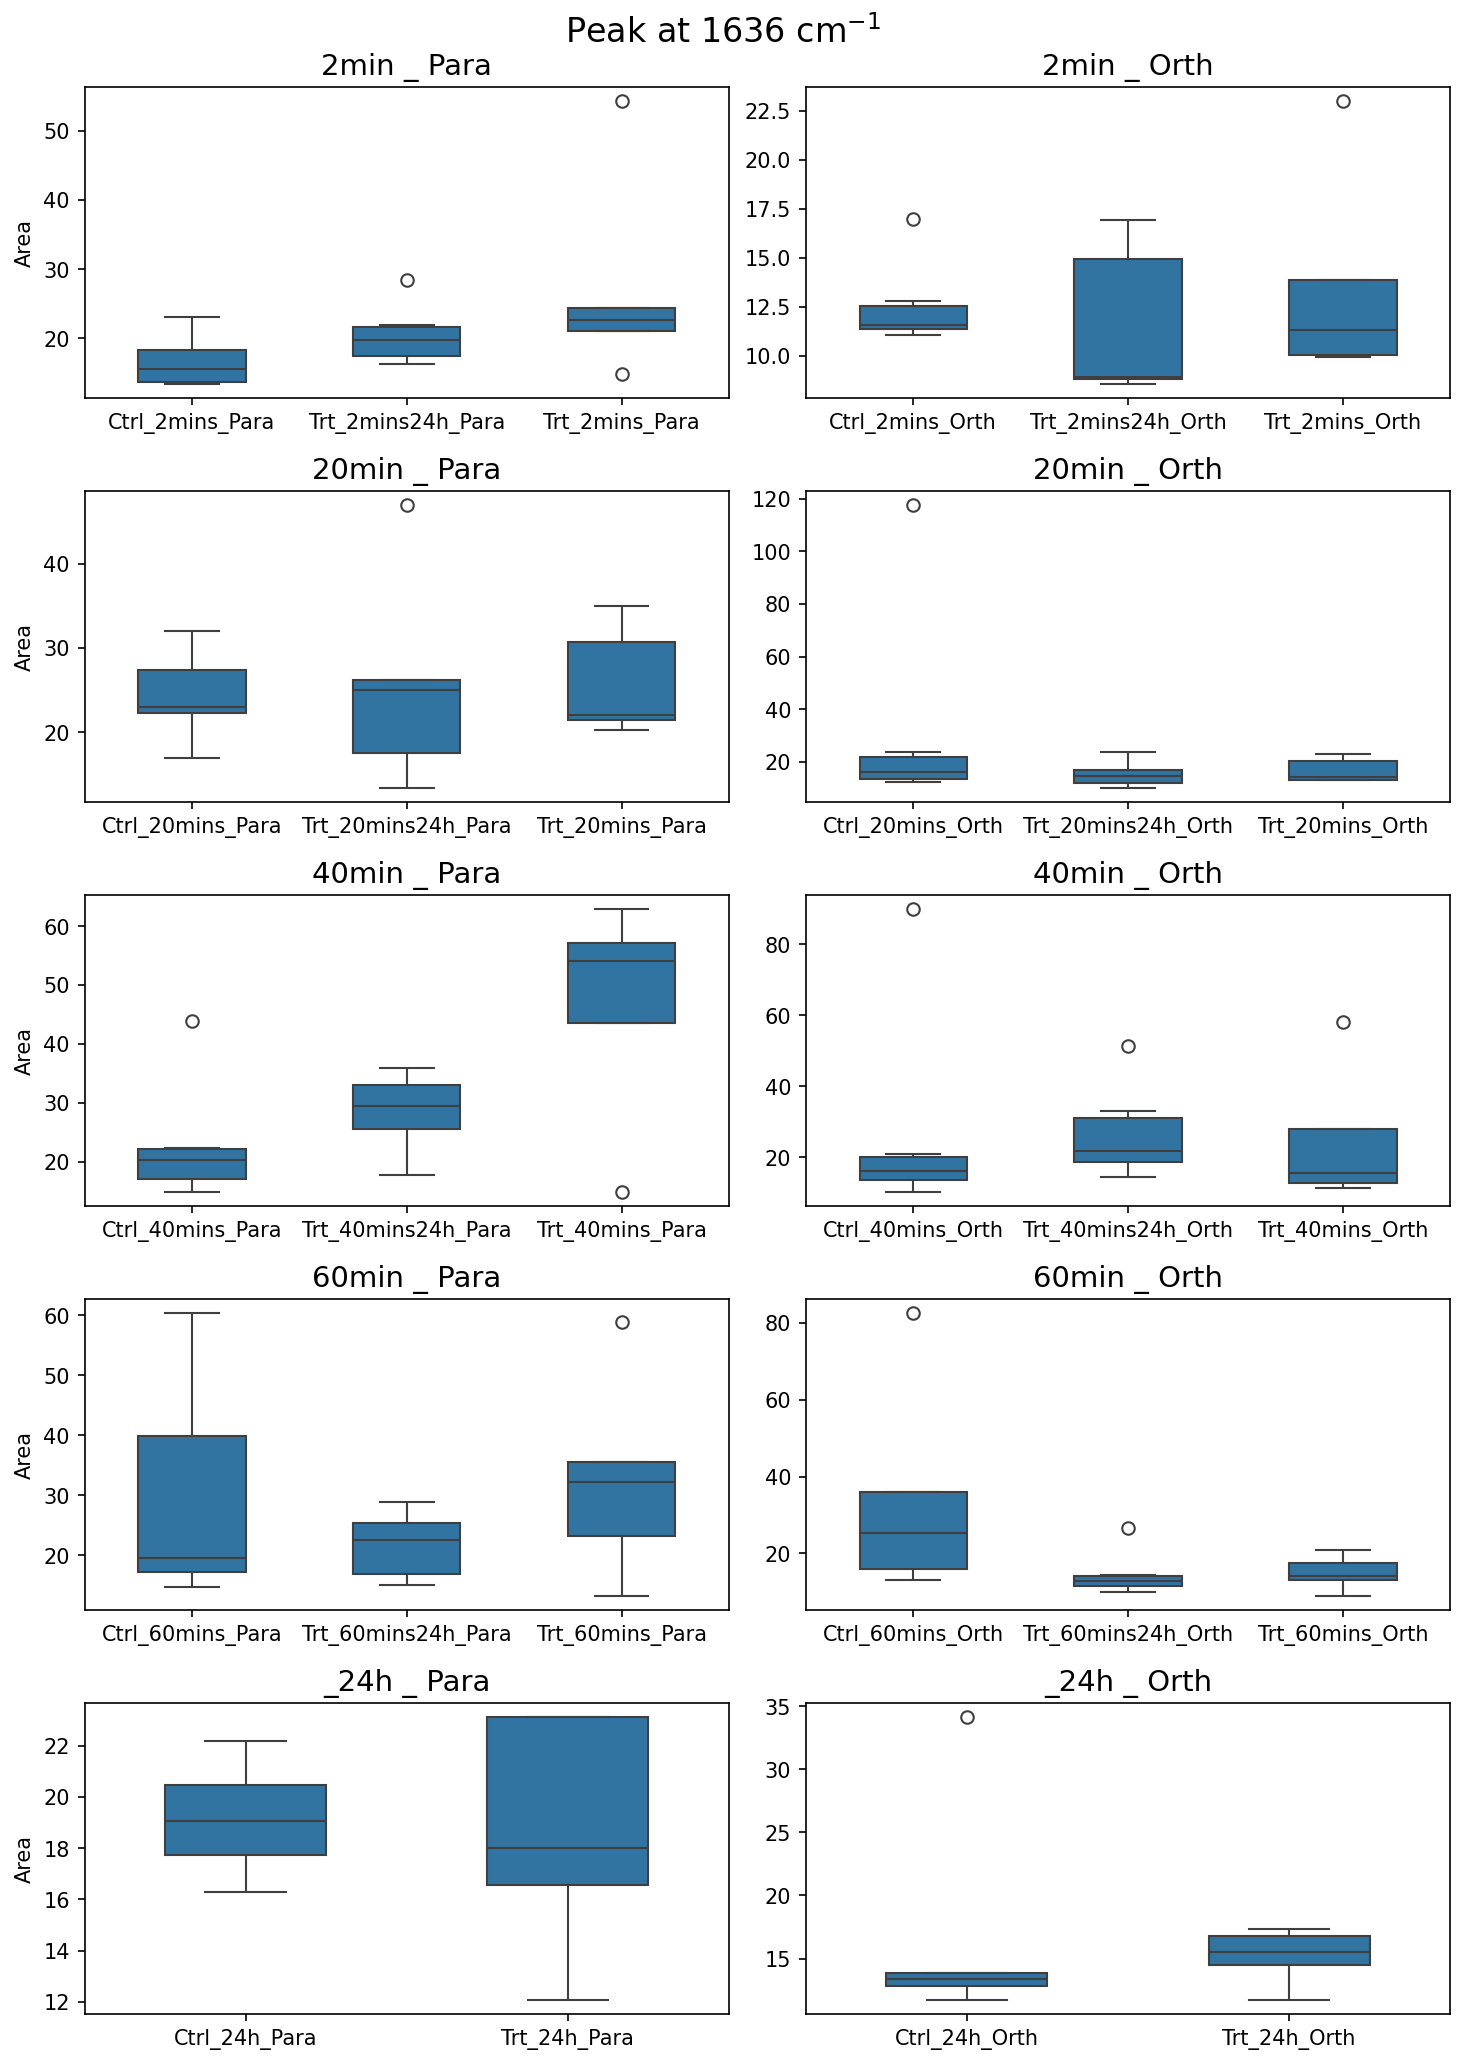

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

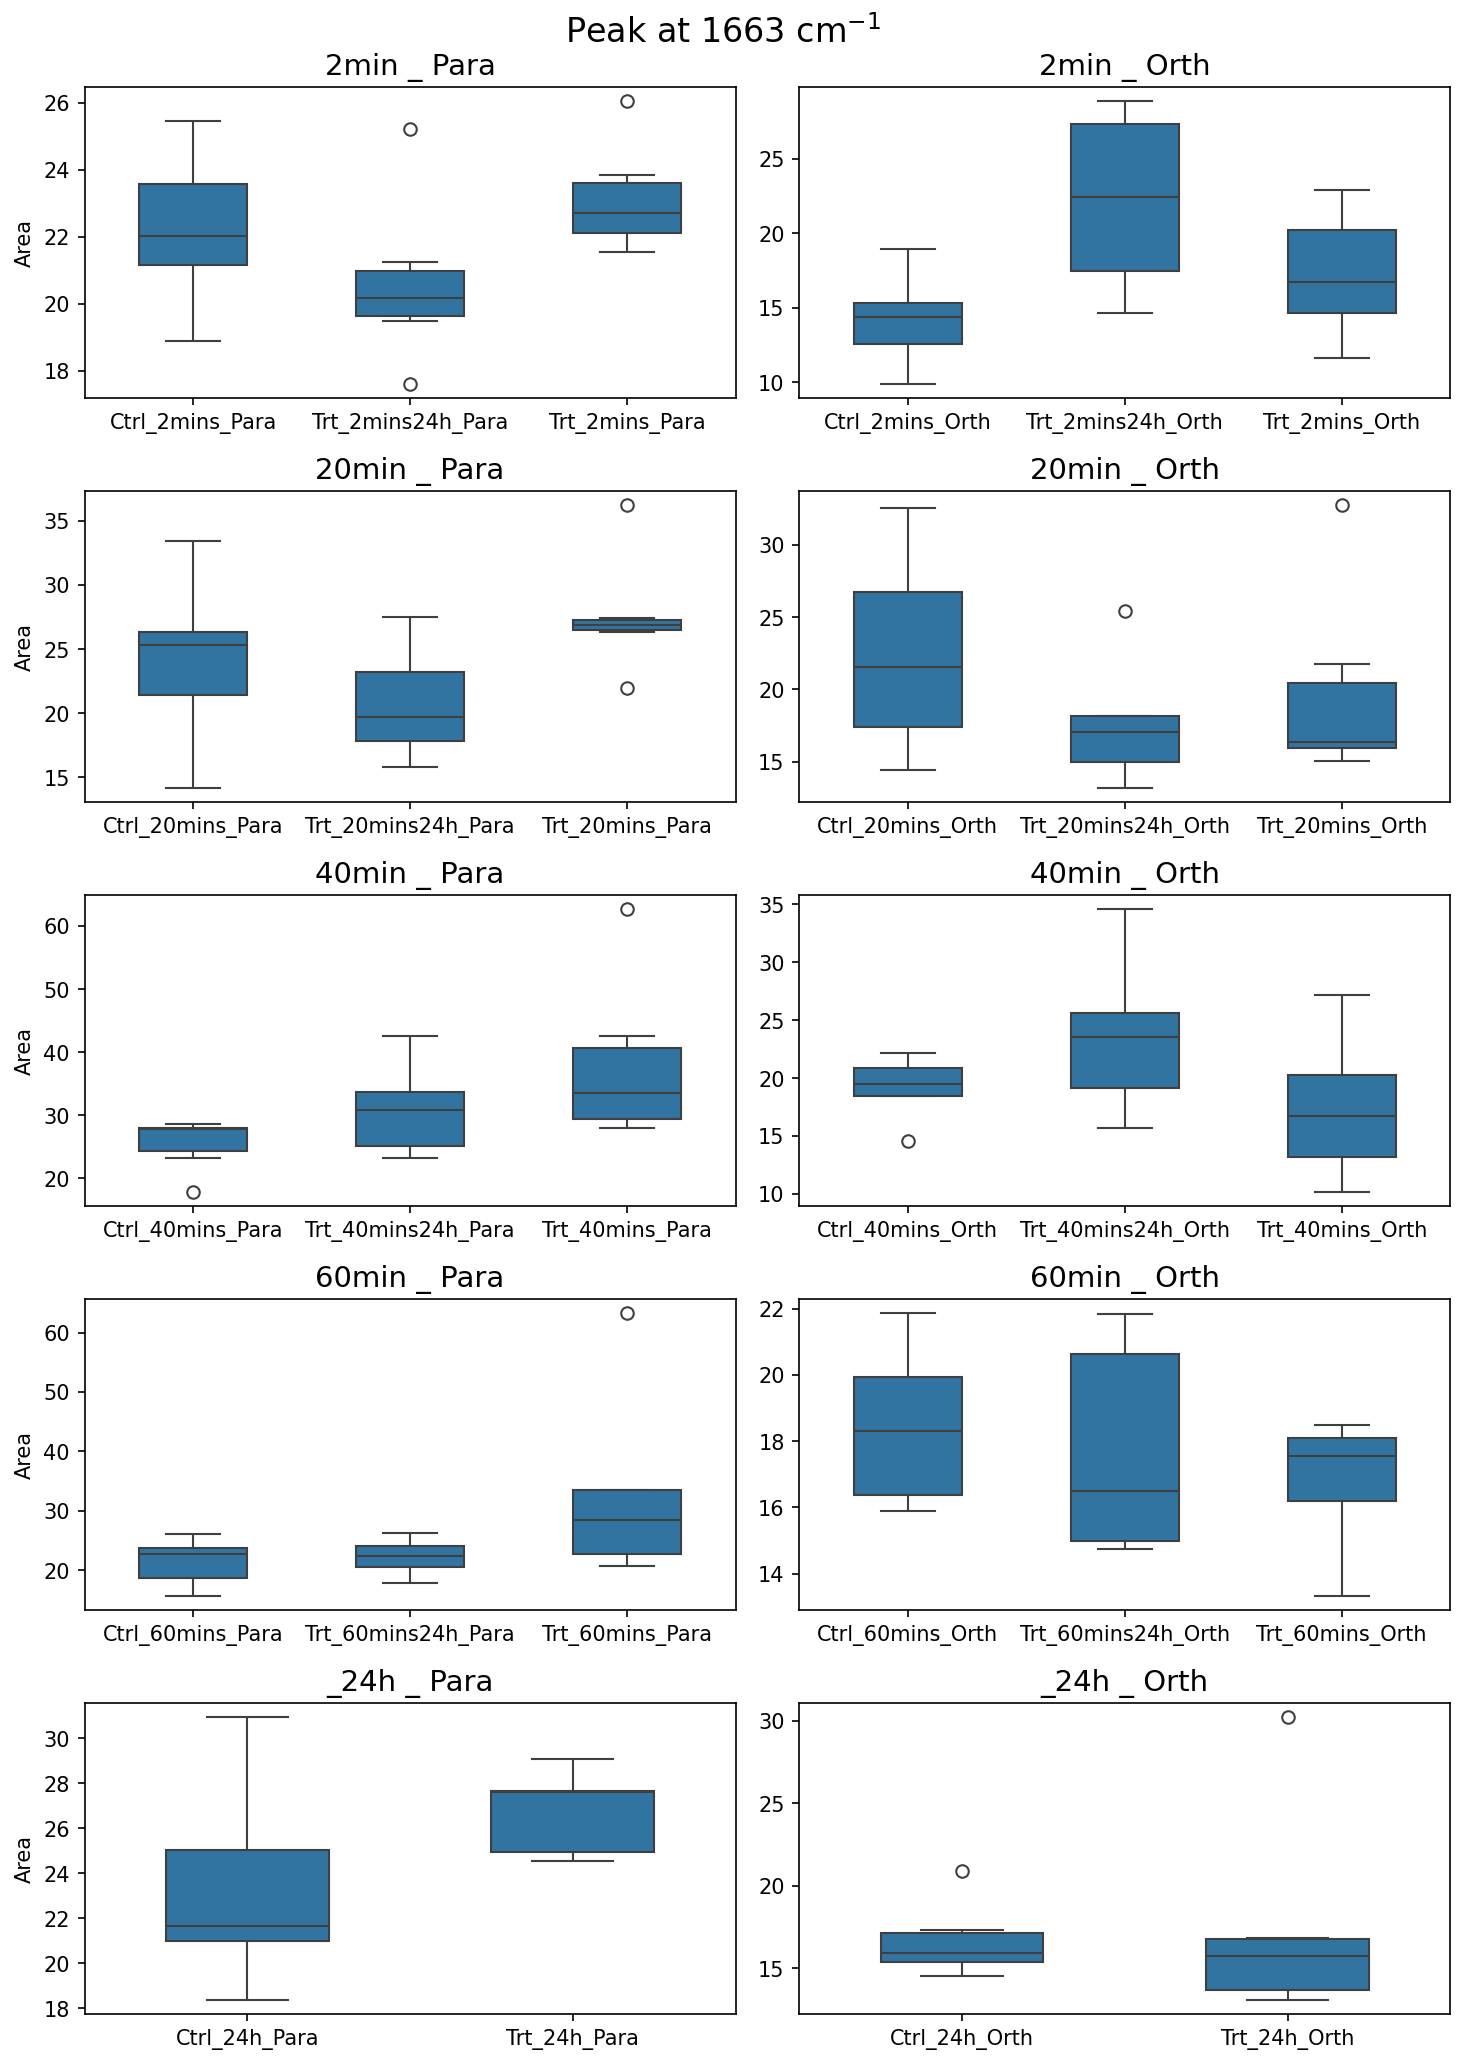

In [ ]:
for p in peak_positions:
    fig, axes = plt.subplots(5, 2, figsize = (10, 14), dpi = 150)
#axes = axes.flatten()


    for i, ort in enumerate(['2min', '20min', '40min', '60min', '_24h']):
        for j, tp in enumerate(['Para', 'Orth']):
            
            ax = axes[i, j]
            subset =  results[
                (results['group'].str.contains(ort)) & 
                (results['group'].str.contains(tp)) & 
                (results['peak_pos'] == p)
                ]
            #print(subset)
            sns.boxplot(
                        data = subset,
                        x = 'group',
                        y = 'area',
                        ax = ax,
                        width = .5
                        );
            ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
            ax.set_title(f"{ort} _ {tp}", fontsize=14);
            ax.set_xlabel("");
            ax.set_ylabel("Area" if j == 0 else "");  # only left column shows y-axis label
    plt.suptitle(f"Peak at {p} cm$^{{-1}}$", fontsize = 16);

    plt.tight_layout();
    plt.show();